# $\textbf{Linear Feedback Shift Registers (LFSRs)}$
$\text{Author: Ryan Burns}$

$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange

# Galois / LFSR utilities
from galois_tools import *

# Plotting functionality
from matplotlib import pyplot as plt

### $\textbf{Specify Degree of Polynomial Over }GF(2)\textbf{ & Seed State for LFSR}$

In [2]:
# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [3]:
# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg)

### $\textbf{Define Set of LFSRs of Specified Degree}$

In [4]:
LFSRs = [
    LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))
]

### $\textbf{Generate Maximum Length Sequences (i.e., }m\textbf{-Sequences) With Each Register}$

In [5]:
# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

# Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

### $\textbf{Visualize Auto- & Cross Correlations of Algebraic } \pm1\textbf{ Representations}$

<IPython.core.display.Javascript object>


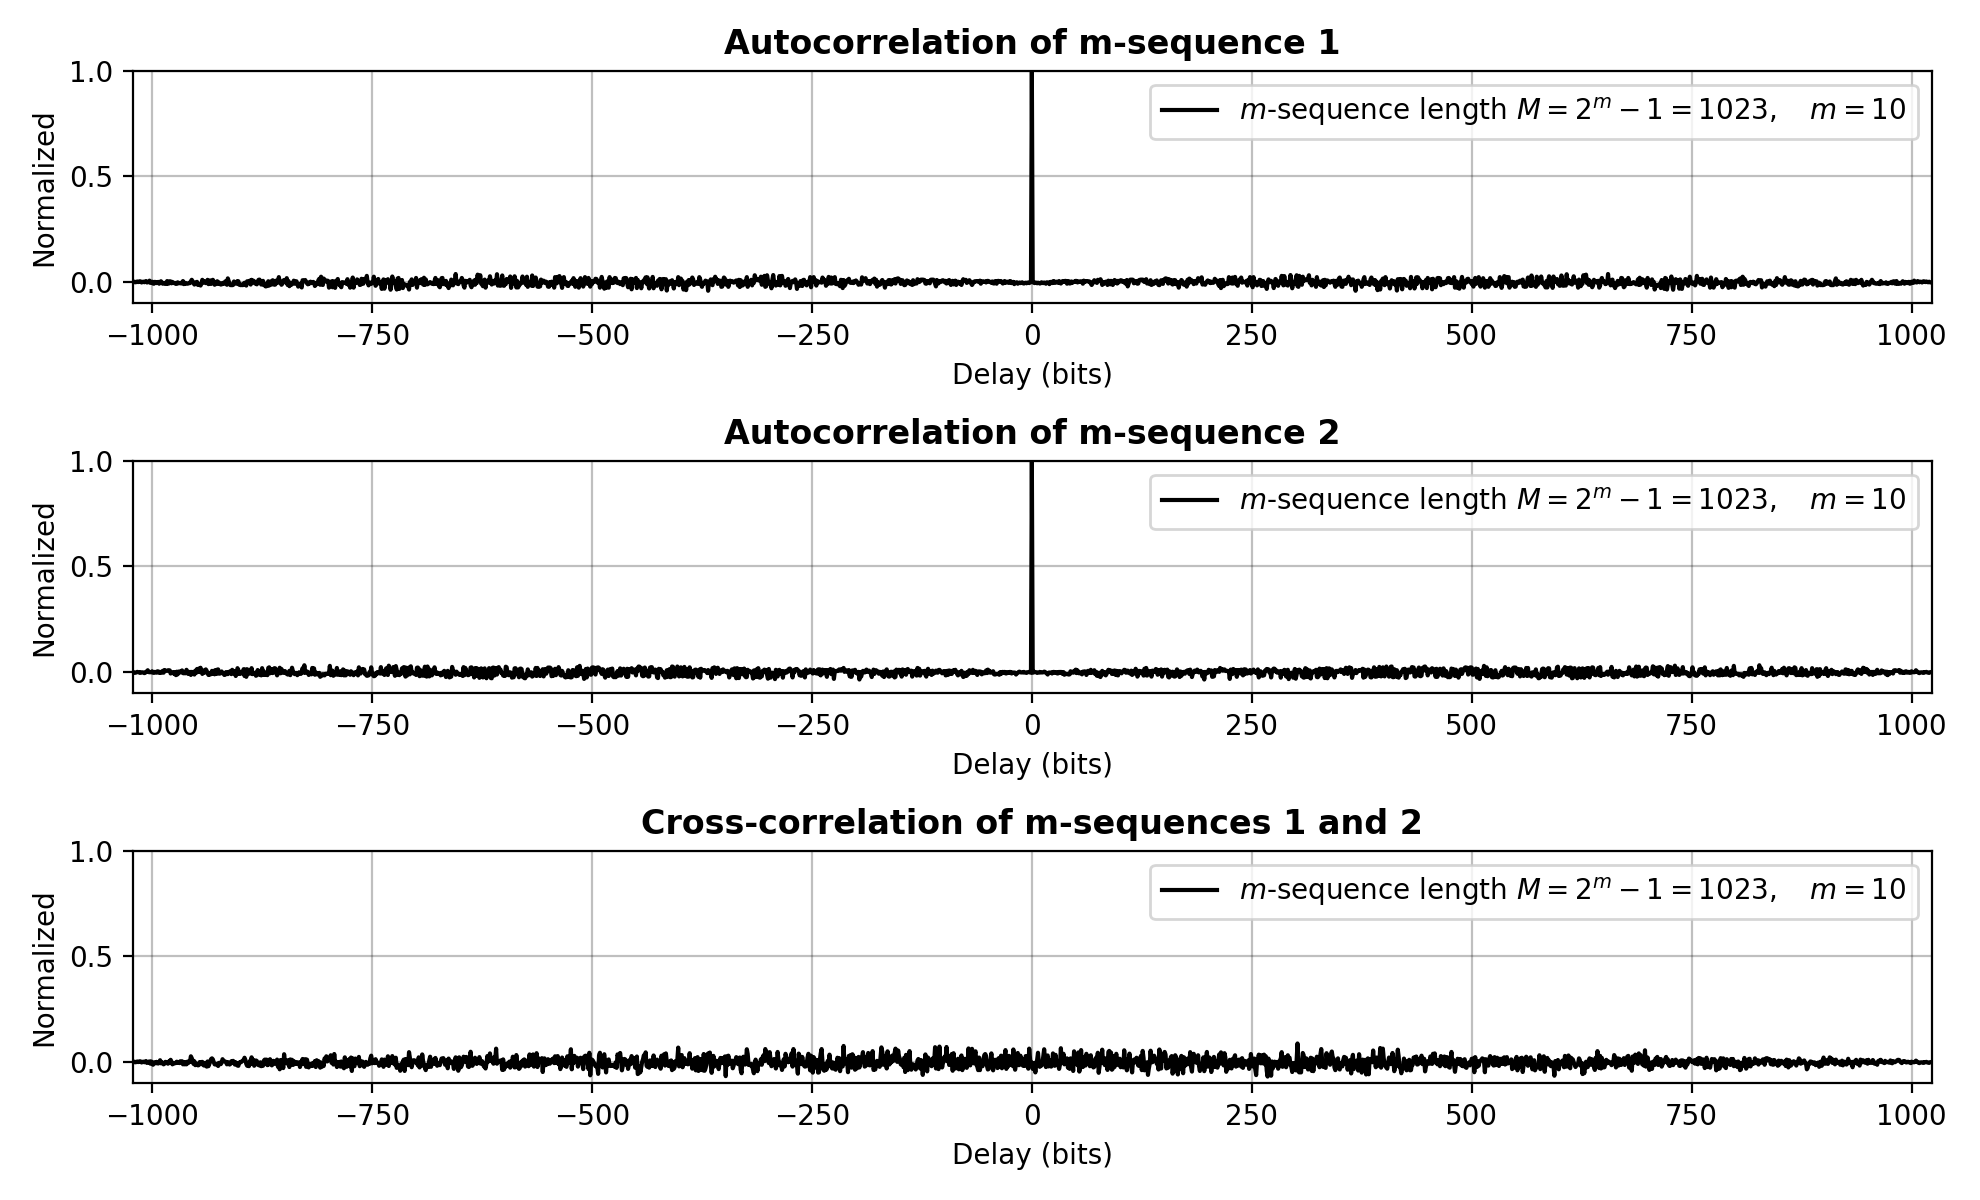

In [6]:
%matplotlib notebook

############################
# Correlation computations #
############################

# Correlation delays (bits/samples)
delays = arange(-M + 1, M)

# Autocorrelations, computed per algebraic m-sequence
autocorrelations = transpose([correlate(b, b, 'full')
    for b in algebraic_m_sequences])

# Cross-correlations of m-sequences 1 & 2 in collection
cross_corr_example = correlate(algebraic_m_sequences[0,:],
    algebraic_m_sequences[1,:],'full') 

######################################
# PLOT: m-sequence 1 autocorrelation #
######################################

# New figure
plt.figure(figsize=(9.9,6));

# Save these axes as ax
ax = plt.subplot(3,1,1);

# Add grid
plt.grid(c='k',alpha=0.25);

# Plot autocorrelation of m-sequence 1 of collection
plt.plot(delays,autocorrelations[:,0]/M,c='k',
    label='$m$-sequence length $M=2^m-1 = ' \
    + str(int(2**deg - 1)) \
    + ',\quad m = ' + str(deg) + '$');

# Set axis limits
plt.xlim([-M+1,M]);
plt.ylim([-0.1,1])

# Title
plt.title(r'Autocorrelation of m-sequence 1',weight='bold')

# Label axes
plt.ylabel(r'Normalized')
plt.xlabel(r'Delay (bits)')

# Legend
plt.legend()

######################################
# PLOT: m-sequence 2 autocorrelation #
######################################

# 2nd subplot on common axis
plt.subplot(3,1,2,sharex=ax);

# Add grid
plt.grid(c='k',alpha=0.25);

# Plot autocorrelation of m-sequence 2 of collection
plt.plot(delays,autocorrelations[:,1]/M,c='k',
    label='$m$-sequence length $M=2^m-1 = ' \
    + str(int(2**deg - 1)) \
    + ',\quad m = ' + str(deg) + '$');

# Set axis limits
plt.xlim([-M+1,M]);
plt.ylim([-0.1,1])

# Title
plt.title(r'Autocorrelation of m-sequence 2',weight='bold')

# Label axes
plt.ylabel(r'Normalized')
plt.xlabel(r'Delay (bits)')

# Legend
plt.legend()

############################################
# PLOT: m-sequence 1 & 2 cross-correlation #
############################################

# 3rd subplot on common axis
plt.subplot(3,1,3,sharex=ax)

# Add grid
plt.grid(c='k',alpha=0.25);

# Plot cross-correlation of m-sequences 1 and 2
plt.plot(delays,cross_corr_example/M,c='k',
    label='$m$-sequence length $M=2^m-1 = ' \
    + str(int(2**deg - 1)) \
    + ',\quad m = ' + str(deg) + '$');

# Set axis limits
plt.xlim([-M+1,M]);
plt.ylim([-0.1,1])

# Title
plt.title(r'Cross-correlation of m-sequences 1 and 2',weight='bold')

# Label axes
plt.ylabel(r'Normalized')
plt.xlabel(r'Delay (bits)')

# Legend
plt.legend()

# Optimize subplot layout
plt.tight_layout()

In [7]:
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, BatchNormalization, Reshape, LSTM
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC, Accuracy;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

In [16]:
p = 9
N_epoch = 15000
pct_validation = 0
N_batch = 2**deg - 1
learning_rate = 0.001

In [17]:
# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
b = vstack(tuple(register.stream(2**deg + deg) for register in LFSRs))
X = array([b[p,n:(n + deg)] for n in range(b.shape[1] - deg - 1)])
Y = array([b[p,(n + deg)] for n in range(b.shape[1] - deg - 1)])

In [18]:
x = Input(shape=(deg,))
h = Dense(deg,activation='sigmoid',use_bias=False)(x)
y = Dense(1,activation='sigmoid',use_bias=False)(h)
model = Model(x,y)

In [19]:
###########################
# Define loss & optimizer #
###########################

# Set RMSprop optimization for 
# speed-of-convergence purposes
opt = RMSprop(
    learning_rate=learning_rate,
    epsilon=1e-07,
    name="RMSprop"
);

# Model compilation, using categorical
# cross-entropy error w/ RMSprop
model.compile(
    
    # Error/loss function
    loss='binary_crossentropy', 
    
    # Use RMSprop
    optimizer=opt,
    
    # List metrics here
    metrics=[
        CategoricalAccuracy(),
        Accuracy(),
        TruePositives(),
        TrueNegatives(),
        FalsePositives(),
        FalseNegatives()
    ]
);

# Print a summary table
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # state vectot "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=pct_validation,
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False
);

Train on 1023 samples
Epoch 1/15000
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.7350 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 512.0000 - true_negatives_1: 0.0000e+00 - false_positives_1: 511.0000 - false_negatives_1: 0.0000e+00
Epoch 2/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7312 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 512.0000 - true_negatives_1: 0.0000e+00 - false_positives_1: 511.0000 - false_negatives_1: 0.0000e+00
Epoch 3/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.7286 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 512.0000 - true_negatives_1: 0.0000e+00 - false_positives_1: 511.0000 - false_negatives_1: 0.0000e+00
Epoch 4/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.7266 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 512.0000 - true_negative

Epoch 32/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.7030 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 508.0000 - true_negatives_1: 2.0000 - false_positives_1: 509.0000 - false_negatives_1: 4.0000
Epoch 33/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.7026 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 508.0000 - true_negatives_1: 3.0000 - false_positives_1: 508.0000 - false_negatives_1: 4.0000
Epoch 34/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.7021 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 508.0000 - true_negatives_1: 4.0000 - false_positives_1: 507.0000 - false_negatives_1: 4.0000
Epoch 35/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.7017 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 508.0000 - true_negatives_1: 4.0000 - false_positives_1: 507.0000 

Epoch 64/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6953 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 123.0000 - false_positives_1: 388.0000 - false_negatives_1: 150.0000
Epoch 65/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6952 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 131.0000 - false_positives_1: 380.0000 - false_negatives_1: 161.0000
Epoch 66/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6952 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 346.0000 - true_negatives_1: 136.0000 - false_positives_1: 375.0000 - false_negatives_1: 166.0000
Epoch 67/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6951 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 341.0000 - true_negatives_1: 143.0000 - false_positive

Epoch 96/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6943 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 271.0000 - true_negatives_1: 231.0000 - false_positives_1: 280.0000 - false_negatives_1: 241.0000
Epoch 97/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6943 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 271.0000 - true_negatives_1: 232.0000 - false_positives_1: 279.0000 - false_negatives_1: 241.0000
Epoch 98/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6943 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 271.0000 - true_negatives_1: 234.0000 - false_positives_1: 277.0000 - false_negatives_1: 241.0000
Epoch 99/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6943 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 271.0000 - true_negatives_1: 234.0000 - false_positive

Epoch 128/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6938 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 271.0000 - true_negatives_1: 244.0000 - false_positives_1: 267.0000 - false_negatives_1: 241.0000
Epoch 129/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6937 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 270.0000 - true_negatives_1: 244.0000 - false_positives_1: 267.0000 - false_negatives_1: 242.0000
Epoch 130/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6937 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 270.0000 - true_negatives_1: 244.0000 - false_positives_1: 267.0000 - false_negatives_1: 242.0000
Epoch 131/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6937 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 269.0000 - true_negatives_1: 244.0000 - false_posi

Epoch 160/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6934 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 270.0000 - true_negatives_1: 246.0000 - false_positives_1: 265.0000 - false_negatives_1: 242.0000
Epoch 161/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6934 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 270.0000 - true_negatives_1: 246.0000 - false_positives_1: 265.0000 - false_negatives_1: 242.0000
Epoch 162/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6934 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 270.0000 - true_negatives_1: 246.0000 - false_positives_1: 265.0000 - false_negatives_1: 242.0000
Epoch 163/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6934 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 270.0000 - true_negatives_1: 248.0000 - false_posi

Epoch 192/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 288.0000 - true_negatives_1: 221.0000 - false_positives_1: 290.0000 - false_negatives_1: 224.0000
Epoch 193/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 259.0000 - true_negatives_1: 259.0000 - false_positives_1: 252.0000 - false_negatives_1: 253.0000
Epoch 194/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 288.0000 - true_negatives_1: 214.0000 - false_positives_1: 297.0000 - false_negatives_1: 224.0000
Epoch 195/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 253.0000 - true_negatives_1: 266.0000 - false_posi

Epoch 224/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 325.0000 - true_negatives_1: 193.0000 - false_positives_1: 318.0000 - false_negatives_1: 187.0000
Epoch 225/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 238.0000 - true_negatives_1: 271.0000 - false_positives_1: 240.0000 - false_negatives_1: 274.0000
Epoch 226/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 329.0000 - true_negatives_1: 183.0000 - false_positives_1: 328.0000 - false_negatives_1: 183.0000
Epoch 227/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 235.0000 - true_negatives_1: 272.0000 - false_posi

Epoch 256/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 157.0000 - false_positives_1: 354.0000 - false_negatives_1: 151.0000
Epoch 257/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 215.0000 - true_negatives_1: 293.0000 - false_positives_1: 218.0000 - false_negatives_1: 297.0000
Epoch 258/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 155.0000 - false_positives_1: 356.0000 - false_negatives_1: 151.0000
Epoch 259/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 213.0000 - true_negatives_1: 293.0000 - false_posi

Epoch 288/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 150.0000 - false_positives_1: 361.0000 - false_negatives_1: 141.0000
Epoch 289/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 202.0000 - true_negatives_1: 303.0000 - false_positives_1: 208.0000 - false_negatives_1: 310.0000
Epoch 290/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 149.0000 - false_positives_1: 362.0000 - false_negatives_1: 142.0000
Epoch 291/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 203.0000 - true_negatives_1: 302.0000 - false_posi

Epoch 320/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 145.0000 - false_positives_1: 366.0000 - false_negatives_1: 140.0000
Epoch 321/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 191.0000 - true_negatives_1: 304.0000 - false_positives_1: 207.0000 - false_negatives_1: 321.0000
Epoch 322/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 145.0000 - false_positives_1: 366.0000 - false_negatives_1: 140.0000
Epoch 323/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 191.0000 - true_negatives_1: 305.0000 - false_posi

Epoch 352/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 147.0000 - false_positives_1: 364.0000 - false_negatives_1: 142.0000
Epoch 353/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 188.0000 - true_negatives_1: 306.0000 - false_positives_1: 205.0000 - false_negatives_1: 324.0000
Epoch 354/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 147.0000 - false_positives_1: 364.0000 - false_negatives_1: 143.0000
Epoch 355/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 188.0000 - true_negatives_1: 306.0000 - false_posi

Epoch 384/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 147.0000 - false_positives_1: 364.0000 - false_negatives_1: 143.0000
Epoch 385/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 189.0000 - true_negatives_1: 307.0000 - false_positives_1: 204.0000 - false_negatives_1: 323.0000
Epoch 386/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 147.0000 - false_positives_1: 364.0000 - false_negatives_1: 143.0000
Epoch 387/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 189.0000 - true_negatives_1: 307.0000 - false_posi

Epoch 416/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 142.0000
Epoch 417/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 188.0000 - true_negatives_1: 309.0000 - false_positives_1: 202.0000 - false_negatives_1: 324.0000
Epoch 418/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 142.0000
Epoch 419/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 188.0000 - true_negatives_1: 309.0000 - false_posi

Epoch 448/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 140.0000
Epoch 449/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 186.0000 - true_negatives_1: 312.0000 - false_positives_1: 199.0000 - false_negatives_1: 326.0000
Epoch 450/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 140.0000
Epoch 451/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 186.0000 - true_negatives_1: 312.0000 - false_posi

Epoch 480/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 147.0000 - false_positives_1: 364.0000 - false_negatives_1: 142.0000
Epoch 481/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 183.0000 - true_negatives_1: 314.0000 - false_positives_1: 197.0000 - false_negatives_1: 329.0000
Epoch 482/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 149.0000 - false_positives_1: 362.0000 - false_negatives_1: 142.0000
Epoch 483/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 183.0000 - true_negatives_1: 314.0000 - false_posi

Epoch 512/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 140.0000
Epoch 513/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 181.0000 - true_negatives_1: 314.0000 - false_positives_1: 197.0000 - false_negatives_1: 331.0000
Epoch 514/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 141.0000
Epoch 515/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 181.0000 - true_negatives_1: 314.0000 - false_posi

Epoch 544/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 141.0000
Epoch 545/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 179.0000 - true_negatives_1: 314.0000 - false_positives_1: 197.0000 - false_negatives_1: 333.0000
Epoch 546/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 149.0000 - false_positives_1: 362.0000 - false_negatives_1: 141.0000
Epoch 547/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 179.0000 - true_negatives_1: 314.0000 - false_posi

Epoch 576/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 151.0000 - false_positives_1: 360.0000 - false_negatives_1: 141.0000
Epoch 577/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 178.0000 - true_negatives_1: 315.0000 - false_positives_1: 196.0000 - false_negatives_1: 334.0000
Epoch 578/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 151.0000 - false_positives_1: 360.0000 - false_negatives_1: 141.0000
Epoch 579/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 178.0000 - true_negatives_1: 316.0000 - false_posi

Epoch 608/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 150.0000 - false_positives_1: 361.0000 - false_negatives_1: 143.0000
Epoch 609/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 177.0000 - true_negatives_1: 319.0000 - false_positives_1: 192.0000 - false_negatives_1: 335.0000
Epoch 610/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 150.0000 - false_positives_1: 361.0000 - false_negatives_1: 143.0000
Epoch 611/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 176.0000 - true_negatives_1: 319.0000 - false_posi

Epoch 640/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 150.0000 - false_positives_1: 361.0000 - false_negatives_1: 142.0000
Epoch 641/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 177.0000 - true_negatives_1: 320.0000 - false_positives_1: 191.0000 - false_negatives_1: 335.0000
Epoch 642/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 150.0000 - false_positives_1: 361.0000 - false_negatives_1: 143.0000
Epoch 643/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 177.0000 - true_negatives_1: 320.0000 - false_posi

Epoch 672/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 151.0000 - false_positives_1: 360.0000 - false_negatives_1: 142.0000
Epoch 673/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 174.0000 - true_negatives_1: 323.0000 - false_positives_1: 188.0000 - false_negatives_1: 338.0000
Epoch 674/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 151.0000 - false_positives_1: 360.0000 - false_negatives_1: 144.0000
Epoch 675/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 173.0000 - true_negatives_1: 323.0000 - false_posi

Epoch 704/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 150.0000 - false_positives_1: 361.0000 - false_negatives_1: 147.0000
Epoch 705/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 172.0000 - true_negatives_1: 328.0000 - false_positives_1: 183.0000 - false_negatives_1: 340.0000
Epoch 706/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 151.0000 - false_positives_1: 360.0000 - false_negatives_1: 146.0000
Epoch 707/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 172.0000 - true_negatives_1: 328.0000 - false_posi

Epoch 736/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 151.0000 - false_positives_1: 360.0000 - false_negatives_1: 149.0000
Epoch 737/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 169.0000 - true_negatives_1: 329.0000 - false_positives_1: 182.0000 - false_negatives_1: 343.0000
Epoch 738/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 151.0000 - false_positives_1: 360.0000 - false_negatives_1: 149.0000
Epoch 739/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 169.0000 - true_negatives_1: 330.0000 - false_posi

Epoch 768/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 153.0000 - false_positives_1: 358.0000 - false_negatives_1: 150.0000
Epoch 769/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 168.0000 - true_negatives_1: 334.0000 - false_positives_1: 177.0000 - false_negatives_1: 344.0000
Epoch 770/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 153.0000 - false_positives_1: 358.0000 - false_negatives_1: 150.0000
Epoch 771/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 168.0000 - true_negatives_1: 334.0000 - false_posi

Epoch 800/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 152.0000
Epoch 801/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 168.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 344.0000
Epoch 802/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 152.0000
Epoch 803/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 169.0000 - true_negatives_1: 337.0000 - false_posi

Epoch 832/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 151.0000
Epoch 833/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 168.0000 - true_negatives_1: 338.0000 - false_positives_1: 173.0000 - false_negatives_1: 344.0000
Epoch 834/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 151.0000
Epoch 835/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 167.0000 - true_negatives_1: 338.0000 - false_posi

Epoch 864/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 150.0000
Epoch 865/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 166.0000 - true_negatives_1: 339.0000 - false_positives_1: 172.0000 - false_negatives_1: 346.0000
Epoch 866/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 150.0000
Epoch 867/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 166.0000 - true_negatives_1: 339.0000 - false_posi

Epoch 896/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 149.0000
Epoch 897/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 162.0000 - true_negatives_1: 340.0000 - false_positives_1: 171.0000 - false_negatives_1: 350.0000
Epoch 898/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 148.0000 - false_positives_1: 363.0000 - false_negatives_1: 148.0000
Epoch 899/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 162.0000 - true_negatives_1: 340.0000 - false_posi

Epoch 928/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 147.0000 - false_positives_1: 364.0000 - false_negatives_1: 151.0000
Epoch 929/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 159.0000 - true_negatives_1: 344.0000 - false_positives_1: 167.0000 - false_negatives_1: 353.0000
Epoch 930/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 147.0000 - false_positives_1: 364.0000 - false_negatives_1: 151.0000
Epoch 931/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 159.0000 - true_negatives_1: 345.0000 - false_posi

Epoch 960/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 147.0000 - false_positives_1: 364.0000 - false_negatives_1: 150.0000
Epoch 961/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 348.0000 - false_positives_1: 163.0000 - false_negatives_1: 354.0000
Epoch 962/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 147.0000 - false_positives_1: 364.0000 - false_negatives_1: 150.0000
Epoch 963/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 348.0000 - false_posi

Epoch 992/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 149.0000 - false_positives_1: 362.0000 - false_negatives_1: 150.0000
Epoch 993/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 159.0000 - true_negatives_1: 348.0000 - false_positives_1: 163.0000 - false_negatives_1: 353.0000
Epoch 994/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 149.0000 - false_positives_1: 362.0000 - false_negatives_1: 150.0000
Epoch 995/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 349.0000 - false_posi

Epoch 1024/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 149.0000 - false_positives_1: 362.0000 - false_negatives_1: 151.0000
Epoch 1025/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 351.0000 - false_positives_1: 160.0000 - false_negatives_1: 354.0000
Epoch 1026/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 150.0000 - false_positives_1: 361.0000 - false_negatives_1: 151.0000
Epoch 1027/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 352.0000 - false_

Epoch 1056/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 154.0000 - false_positives_1: 357.0000 - false_negatives_1: 149.0000
Epoch 1057/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 355.0000 - false_positives_1: 156.0000 - false_negatives_1: 354.0000
Epoch 1058/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 154.0000 - false_positives_1: 357.0000 - false_negatives_1: 149.0000
Epoch 1059/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 355.0000 - false_

Epoch 1088/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 156.0000 - false_positives_1: 355.0000 - false_negatives_1: 149.0000
Epoch 1089/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 355.0000 - false_positives_1: 156.0000 - false_negatives_1: 354.0000
Epoch 1090/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 156.0000 - false_positives_1: 355.0000 - false_negatives_1: 149.0000
Epoch 1091/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 355.0000 - false_

Epoch 1120/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 156.0000 - false_positives_1: 355.0000 - false_negatives_1: 151.0000
Epoch 1121/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 155.0000 - true_negatives_1: 355.0000 - false_positives_1: 156.0000 - false_negatives_1: 357.0000
Epoch 1122/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 156.0000 - false_positives_1: 355.0000 - false_negatives_1: 151.0000
Epoch 1123/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 155.0000 - true_negatives_1: 355.0000 - false_

Epoch 1152/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 158.0000 - false_positives_1: 353.0000 - false_negatives_1: 156.0000
Epoch 1153/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 151.0000 - true_negatives_1: 357.0000 - false_positives_1: 154.0000 - false_negatives_1: 361.0000
Epoch 1154/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 158.0000 - false_positives_1: 353.0000 - false_negatives_1: 156.0000
Epoch 1155/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 151.0000 - true_negatives_1: 357.0000 - false_

Epoch 1184/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 159.0000 - false_positives_1: 352.0000 - false_negatives_1: 156.0000
Epoch 1185/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 153.0000 - true_negatives_1: 358.0000 - false_positives_1: 153.0000 - false_negatives_1: 359.0000
Epoch 1186/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 159.0000 - false_positives_1: 352.0000 - false_negatives_1: 156.0000
Epoch 1187/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 153.0000 - true_negatives_1: 358.0000 - false_

Epoch 1216/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 160.0000 - false_positives_1: 351.0000 - false_negatives_1: 155.0000
Epoch 1217/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 152.0000 - true_negatives_1: 362.0000 - false_positives_1: 149.0000 - false_negatives_1: 360.0000
Epoch 1218/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 160.0000 - false_positives_1: 351.0000 - false_negatives_1: 155.0000
Epoch 1219/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 152.0000 - true_negatives_1: 362.0000 - false_

Epoch 1248/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 162.0000 - false_positives_1: 349.0000 - false_negatives_1: 156.0000
Epoch 1249/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 153.0000 - true_negatives_1: 360.0000 - false_positives_1: 151.0000 - false_negatives_1: 359.0000
Epoch 1250/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 162.0000 - false_positives_1: 349.0000 - false_negatives_1: 156.0000
Epoch 1251/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 153.0000 - true_negatives_1: 360.0000 - false_

Epoch 1280/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 164.0000 - false_positives_1: 347.0000 - false_negatives_1: 159.0000
Epoch 1281/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 151.0000 - true_negatives_1: 361.0000 - false_positives_1: 150.0000 - false_negatives_1: 361.0000
Epoch 1282/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 164.0000 - false_positives_1: 347.0000 - false_negatives_1: 159.0000
Epoch 1283/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 151.0000 - true_negatives_1: 361.0000 - false_

Epoch 1312/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 165.0000 - false_positives_1: 346.0000 - false_negatives_1: 159.0000
Epoch 1313/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 151.0000 - true_negatives_1: 362.0000 - false_positives_1: 149.0000 - false_negatives_1: 361.0000
Epoch 1314/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 165.0000 - false_positives_1: 346.0000 - false_negatives_1: 159.0000
Epoch 1315/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 151.0000 - true_negatives_1: 362.0000 - false_

Epoch 1344/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 164.0000 - false_positives_1: 347.0000 - false_negatives_1: 161.0000
Epoch 1345/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 151.0000 - true_negatives_1: 364.0000 - false_positives_1: 147.0000 - false_negatives_1: 361.0000
Epoch 1346/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 164.0000 - false_positives_1: 347.0000 - false_negatives_1: 160.0000
Epoch 1347/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 151.0000 - true_negatives_1: 364.0000 - false_

Epoch 1376/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 350.0000 - true_negatives_1: 164.0000 - false_positives_1: 347.0000 - false_negatives_1: 162.0000
Epoch 1377/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 149.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 363.0000
Epoch 1378/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 350.0000 - true_negatives_1: 165.0000 - false_positives_1: 346.0000 - false_negatives_1: 162.0000
Epoch 1379/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 148.0000 - true_negatives_1: 362.0000 - false_

Epoch 1408/15000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 167.0000 - false_positives_1: 344.0000 - false_negatives_1: 161.0000
Epoch 1409/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 146.0000 - true_negatives_1: 364.0000 - false_positives_1: 147.0000 - false_negatives_1: 366.0000
Epoch 1410/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 168.0000 - false_positives_1: 343.0000 - false_negatives_1: 161.0000
Epoch 1411/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 146.0000 - true_negatives_1: 364.0000 - false_

Epoch 1440/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 349.0000 - true_negatives_1: 169.0000 - false_positives_1: 342.0000 - false_negatives_1: 163.0000
Epoch 1441/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 147.0000 - true_negatives_1: 362.0000 - false_positives_1: 149.0000 - false_negatives_1: 365.0000
Epoch 1442/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 349.0000 - true_negatives_1: 170.0000 - false_positives_1: 341.0000 - false_negatives_1: 163.0000
Epoch 1443/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 146.0000 - true_negatives_1: 363.0000 - false_

Epoch 1472/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 348.0000 - true_negatives_1: 172.0000 - false_positives_1: 339.0000 - false_negatives_1: 164.0000
Epoch 1473/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 144.0000 - true_negatives_1: 364.0000 - false_positives_1: 147.0000 - false_negatives_1: 368.0000
Epoch 1474/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 348.0000 - true_negatives_1: 172.0000 - false_positives_1: 339.0000 - false_negatives_1: 164.0000
Epoch 1475/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 144.0000 - true_negatives_1: 365.0000 - false_

Epoch 1504/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 347.0000 - true_negatives_1: 171.0000 - false_positives_1: 340.0000 - false_negatives_1: 165.0000
Epoch 1505/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 145.0000 - true_negatives_1: 366.0000 - false_positives_1: 145.0000 - false_negatives_1: 367.0000
Epoch 1506/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 346.0000 - true_negatives_1: 171.0000 - false_positives_1: 340.0000 - false_negatives_1: 166.0000
Epoch 1507/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 144.0000 - true_negatives_1: 366.0000 - false_

Epoch 1536/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 344.0000 - true_negatives_1: 172.0000 - false_positives_1: 339.0000 - false_negatives_1: 168.0000
Epoch 1537/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 143.0000 - true_negatives_1: 367.0000 - false_positives_1: 144.0000 - false_negatives_1: 369.0000
Epoch 1538/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 344.0000 - true_negatives_1: 172.0000 - false_positives_1: 339.0000 - false_negatives_1: 168.0000
Epoch 1539/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 143.0000 - true_negatives_1: 367.0000 - false_

Epoch 1568/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 342.0000 - true_negatives_1: 174.0000 - false_positives_1: 337.0000 - false_negatives_1: 170.0000
Epoch 1569/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 141.0000 - true_negatives_1: 366.0000 - false_positives_1: 145.0000 - false_negatives_1: 371.0000
Epoch 1570/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 340.0000 - true_negatives_1: 174.0000 - false_positives_1: 337.0000 - false_negatives_1: 172.0000
Epoch 1571/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 141.0000 - true_negatives_1: 366.0000 - false_

Epoch 1600/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 340.0000 - true_negatives_1: 175.0000 - false_positives_1: 336.0000 - false_negatives_1: 172.0000
Epoch 1601/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 136.0000 - true_negatives_1: 370.0000 - false_positives_1: 141.0000 - false_negatives_1: 376.0000
Epoch 1602/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 340.0000 - true_negatives_1: 175.0000 - false_positives_1: 336.0000 - false_negatives_1: 172.0000
Epoch 1603/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 136.0000 - true_negatives_1: 370.0000 - false_

Epoch 1632/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 336.0000 - true_negatives_1: 175.0000 - false_positives_1: 336.0000 - false_negatives_1: 176.0000
Epoch 1633/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 137.0000 - true_negatives_1: 370.0000 - false_positives_1: 141.0000 - false_negatives_1: 375.0000
Epoch 1634/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 336.0000 - true_negatives_1: 175.0000 - false_positives_1: 336.0000 - false_negatives_1: 176.0000
Epoch 1635/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 137.0000 - true_negatives_1: 370.0000 - false_

Epoch 1664/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 333.0000 - true_negatives_1: 175.0000 - false_positives_1: 336.0000 - false_negatives_1: 179.0000
Epoch 1665/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 136.0000 - true_negatives_1: 374.0000 - false_positives_1: 137.0000 - false_negatives_1: 376.0000
Epoch 1666/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 332.0000 - true_negatives_1: 175.0000 - false_positives_1: 336.0000 - false_negatives_1: 180.0000
Epoch 1667/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 136.0000 - true_negatives_1: 374.0000 - false_

Epoch 1696/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 330.0000 - true_negatives_1: 178.0000 - false_positives_1: 333.0000 - false_negatives_1: 182.0000
Epoch 1697/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 135.0000 - true_negatives_1: 376.0000 - false_positives_1: 135.0000 - false_negatives_1: 377.0000
Epoch 1698/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 331.0000 - true_negatives_1: 178.0000 - false_positives_1: 333.0000 - false_negatives_1: 181.0000
Epoch 1699/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 135.0000 - true_negatives_1: 376.0000 - false_

Epoch 1728/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 184.0000
Epoch 1729/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 135.0000 - true_negatives_1: 375.0000 - false_positives_1: 136.0000 - false_negatives_1: 377.0000
Epoch 1730/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 327.0000 - true_negatives_1: 179.0000 - false_positives_1: 332.0000 - false_negatives_1: 185.0000
Epoch 1731/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 135.0000 - true_negatives_1: 375.0000 - false_

Epoch 1760/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 330.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 182.0000
Epoch 1761/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 135.0000 - true_negatives_1: 376.0000 - false_positives_1: 135.0000 - false_negatives_1: 377.0000
Epoch 1762/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 330.0000 - true_negatives_1: 181.0000 - false_positives_1: 330.0000 - false_negatives_1: 182.0000
Epoch 1763/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 135.0000 - true_negatives_1: 376.0000 - false_

Epoch 1792/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 329.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 183.0000
Epoch 1793/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 376.0000 - false_positives_1: 135.0000 - false_negatives_1: 379.0000
Epoch 1794/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 329.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 183.0000
Epoch 1795/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 375.0000 - false_

Epoch 1824/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 330.0000 - true_negatives_1: 178.0000 - false_positives_1: 333.0000 - false_negatives_1: 182.0000
Epoch 1825/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 375.0000 - false_positives_1: 136.0000 - false_negatives_1: 379.0000
Epoch 1826/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 330.0000 - true_negatives_1: 178.0000 - false_positives_1: 333.0000 - false_negatives_1: 182.0000
Epoch 1827/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 375.0000 - false_

Epoch 1856/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 177.0000 - false_positives_1: 334.0000 - false_negatives_1: 184.0000
Epoch 1857/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 376.0000 - false_positives_1: 135.0000 - false_negatives_1: 379.0000
Epoch 1858/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 177.0000 - false_positives_1: 334.0000 - false_negatives_1: 184.0000
Epoch 1859/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 376.0000 - false_

Epoch 1888/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 184.0000
Epoch 1889/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 135.0000 - true_negatives_1: 377.0000 - false_positives_1: 134.0000 - false_negatives_1: 377.0000
Epoch 1890/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 184.0000
Epoch 1891/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 135.0000 - true_negatives_1: 377.0000 - false_

Epoch 1920/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 326.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 186.0000
Epoch 1921/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 134.0000 - true_negatives_1: 377.0000 - false_positives_1: 134.0000 - false_negatives_1: 378.0000
Epoch 1922/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 327.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 185.0000
Epoch 1923/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 134.0000 - true_negatives_1: 377.0000 - false_

Epoch 1952/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 184.0000
Epoch 1953/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 378.0000 - false_positives_1: 133.0000 - false_negatives_1: 379.0000
Epoch 1954/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 329.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 183.0000
Epoch 1955/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 378.0000 - false_

Epoch 1984/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 183.0000 - false_positives_1: 328.0000 - false_negatives_1: 184.0000
Epoch 1985/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 377.0000 - false_positives_1: 134.0000 - false_negatives_1: 379.0000
Epoch 1986/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 183.0000 - false_positives_1: 328.0000 - false_negatives_1: 184.0000
Epoch 1987/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 377.0000 - false_

Epoch 2016/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 325.0000 - true_negatives_1: 178.0000 - false_positives_1: 333.0000 - false_negatives_1: 187.0000
Epoch 2017/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 134.0000 - true_negatives_1: 379.0000 - false_positives_1: 132.0000 - false_negatives_1: 378.0000
Epoch 2018/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 178.0000 - false_positives_1: 333.0000 - false_negatives_1: 188.0000
Epoch 2019/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 134.0000 - true_negatives_1: 380.0000 - false_

Epoch 2048/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 179.0000 - false_positives_1: 332.0000 - false_negatives_1: 188.0000
Epoch 2049/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 134.0000 - true_negatives_1: 378.0000 - false_positives_1: 133.0000 - false_negatives_1: 378.0000
Epoch 2050/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 179.0000 - false_positives_1: 332.0000 - false_negatives_1: 188.0000
Epoch 2051/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 134.0000 - true_negatives_1: 378.0000 - false_

Epoch 2080/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 322.0000 - true_negatives_1: 179.0000 - false_positives_1: 332.0000 - false_negatives_1: 190.0000
Epoch 2081/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 131.0000 - true_negatives_1: 378.0000 - false_positives_1: 133.0000 - false_negatives_1: 381.0000
Epoch 2082/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 323.0000 - true_negatives_1: 180.0000 - false_positives_1: 331.0000 - false_negatives_1: 189.0000
Epoch 2083/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 131.0000 - true_negatives_1: 378.0000 - false_

Epoch 2112/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 177.0000 - false_positives_1: 334.0000 - false_negatives_1: 188.0000
Epoch 2113/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 377.0000 - false_positives_1: 134.0000 - false_negatives_1: 379.0000
Epoch 2114/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 178.0000 - false_positives_1: 333.0000 - false_negatives_1: 188.0000
Epoch 2115/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 378.0000 - false_

Epoch 2144/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 178.0000 - false_positives_1: 333.0000 - false_negatives_1: 188.0000
Epoch 2145/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 378.0000 - false_positives_1: 133.0000 - false_negatives_1: 379.0000
Epoch 2146/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 178.0000 - false_positives_1: 333.0000 - false_negatives_1: 188.0000
Epoch 2147/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 378.0000 - false_

Epoch 2176/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 174.0000 - false_positives_1: 337.0000 - false_negatives_1: 188.0000
Epoch 2177/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 378.0000 - false_positives_1: 133.0000 - false_negatives_1: 379.0000
Epoch 2178/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 174.0000 - false_positives_1: 337.0000 - false_negatives_1: 188.0000
Epoch 2179/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 378.0000 - false_

Epoch 2208/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 327.0000 - true_negatives_1: 174.0000 - false_positives_1: 337.0000 - false_negatives_1: 185.0000
Epoch 2209/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 133.0000 - true_negatives_1: 380.0000 - false_positives_1: 131.0000 - false_negatives_1: 379.0000
Epoch 2210/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 327.0000 - true_negatives_1: 174.0000 - false_positives_1: 337.0000 - false_negatives_1: 185.0000
Epoch 2211/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 132.0000 - true_negatives_1: 380.0000 - false_

Epoch 2240/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 325.0000 - true_negatives_1: 172.0000 - false_positives_1: 339.0000 - false_negatives_1: 187.0000
Epoch 2241/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 132.0000 - true_negatives_1: 382.0000 - false_positives_1: 129.0000 - false_negatives_1: 380.0000
Epoch 2242/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 325.0000 - true_negatives_1: 172.0000 - false_positives_1: 339.0000 - false_negatives_1: 187.0000
Epoch 2243/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 132.0000 - true_negatives_1: 382.0000 - false_

Epoch 2272/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 171.0000 - false_positives_1: 340.0000 - false_negatives_1: 188.0000
Epoch 2273/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 130.0000 - true_negatives_1: 381.0000 - false_positives_1: 130.0000 - false_negatives_1: 382.0000
Epoch 2274/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 324.0000 - true_negatives_1: 171.0000 - false_positives_1: 340.0000 - false_negatives_1: 188.0000
Epoch 2275/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 129.0000 - true_negatives_1: 381.0000 - false_

Epoch 2304/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 319.0000 - true_negatives_1: 166.0000 - false_positives_1: 345.0000 - false_negatives_1: 193.0000
Epoch 2305/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 129.0000 - true_negatives_1: 383.0000 - false_positives_1: 128.0000 - false_negatives_1: 383.0000
Epoch 2306/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 319.0000 - true_negatives_1: 167.0000 - false_positives_1: 344.0000 - false_negatives_1: 193.0000
Epoch 2307/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 129.0000 - true_negatives_1: 383.0000 - false_

Epoch 2336/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 316.0000 - true_negatives_1: 166.0000 - false_positives_1: 345.0000 - false_negatives_1: 196.0000
Epoch 2337/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 129.0000 - true_negatives_1: 383.0000 - false_positives_1: 128.0000 - false_negatives_1: 383.0000
Epoch 2338/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 316.0000 - true_negatives_1: 166.0000 - false_positives_1: 345.0000 - false_negatives_1: 196.0000
Epoch 2339/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 128.0000 - true_negatives_1: 383.0000 - false_

Epoch 2368/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 311.0000 - true_negatives_1: 171.0000 - false_positives_1: 340.0000 - false_negatives_1: 201.0000
Epoch 2369/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 127.0000 - true_negatives_1: 384.0000 - false_positives_1: 127.0000 - false_negatives_1: 385.0000
Epoch 2370/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 311.0000 - true_negatives_1: 171.0000 - false_positives_1: 340.0000 - false_negatives_1: 201.0000
Epoch 2371/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 127.0000 - true_negatives_1: 384.0000 - false_

Epoch 2400/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 306.0000 - true_negatives_1: 171.0000 - false_positives_1: 340.0000 - false_negatives_1: 206.0000
Epoch 2401/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 125.0000 - true_negatives_1: 384.0000 - false_positives_1: 127.0000 - false_negatives_1: 387.0000
Epoch 2402/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 304.0000 - true_negatives_1: 171.0000 - false_positives_1: 340.0000 - false_negatives_1: 208.0000
Epoch 2403/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 125.0000 - true_negatives_1: 386.0000 - false_

Epoch 2432/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 300.0000 - true_negatives_1: 171.0000 - false_positives_1: 340.0000 - false_negatives_1: 212.0000
Epoch 2433/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 125.0000 - true_negatives_1: 388.0000 - false_positives_1: 123.0000 - false_negatives_1: 387.0000
Epoch 2434/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 299.0000 - true_negatives_1: 169.0000 - false_positives_1: 342.0000 - false_negatives_1: 213.0000
Epoch 2435/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 125.0000 - true_negatives_1: 388.0000 - false_

Epoch 2464/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 292.0000 - true_negatives_1: 167.0000 - false_positives_1: 344.0000 - false_negatives_1: 220.0000
Epoch 2465/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 124.0000 - true_negatives_1: 387.0000 - false_positives_1: 124.0000 - false_negatives_1: 388.0000
Epoch 2466/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 292.0000 - true_negatives_1: 167.0000 - false_positives_1: 344.0000 - false_negatives_1: 220.0000
Epoch 2467/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 124.0000 - true_negatives_1: 387.0000 - false_

Epoch 2496/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 279.0000 - true_negatives_1: 168.0000 - false_positives_1: 343.0000 - false_negatives_1: 233.0000
Epoch 2497/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 127.0000 - true_negatives_1: 387.0000 - false_positives_1: 124.0000 - false_negatives_1: 385.0000
Epoch 2498/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 279.0000 - true_negatives_1: 168.0000 - false_positives_1: 343.0000 - false_negatives_1: 233.0000
Epoch 2499/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 127.0000 - true_negatives_1: 387.0000 - false_

Epoch 2528/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 269.0000 - true_negatives_1: 165.0000 - false_positives_1: 346.0000 - false_negatives_1: 243.0000
Epoch 2529/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 130.0000 - true_negatives_1: 390.0000 - false_positives_1: 121.0000 - false_negatives_1: 382.0000
Epoch 2530/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 269.0000 - true_negatives_1: 165.0000 - false_positives_1: 346.0000 - false_negatives_1: 243.0000
Epoch 2531/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 131.0000 - true_negatives_1: 390.0000 - false_

Epoch 2560/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 268.0000 - true_negatives_1: 166.0000 - false_positives_1: 345.0000 - false_negatives_1: 244.0000
Epoch 2561/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 134.0000 - true_negatives_1: 391.0000 - false_positives_1: 120.0000 - false_negatives_1: 378.0000
Epoch 2562/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 268.0000 - true_negatives_1: 166.0000 - false_positives_1: 345.0000 - false_negatives_1: 244.0000
Epoch 2563/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 134.0000 - true_negatives_1: 391.0000 - false_

Epoch 2592/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 264.0000 - true_negatives_1: 166.0000 - false_positives_1: 345.0000 - false_negatives_1: 248.0000
Epoch 2593/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 140.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 372.0000
Epoch 2594/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 264.0000 - true_negatives_1: 166.0000 - false_positives_1: 345.0000 - false_negatives_1: 248.0000
Epoch 2595/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 140.0000 - true_negatives_1: 393.0000 - false_

Epoch 2624/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 262.0000 - true_negatives_1: 172.0000 - false_positives_1: 339.0000 - false_negatives_1: 250.0000
Epoch 2625/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 145.0000 - true_negatives_1: 396.0000 - false_positives_1: 115.0000 - false_negatives_1: 367.0000
Epoch 2626/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 261.0000 - true_negatives_1: 172.0000 - false_positives_1: 339.0000 - false_negatives_1: 251.0000
Epoch 2627/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 145.0000 - true_negatives_1: 398.0000 - false_

Epoch 2656/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 257.0000 - true_negatives_1: 175.0000 - false_positives_1: 336.0000 - false_negatives_1: 255.0000
Epoch 2657/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 150.0000 - true_negatives_1: 402.0000 - false_positives_1: 109.0000 - false_negatives_1: 362.0000
Epoch 2658/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 256.0000 - true_negatives_1: 176.0000 - false_positives_1: 335.0000 - false_negatives_1: 256.0000
Epoch 2659/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 150.0000 - true_negatives_1: 402.0000 - false_

Epoch 2688/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 247.0000 - true_negatives_1: 181.0000 - false_positives_1: 330.0000 - false_negatives_1: 265.0000
Epoch 2689/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 157.0000 - true_negatives_1: 407.0000 - false_positives_1: 104.0000 - false_negatives_1: 355.0000
Epoch 2690/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 247.0000 - true_negatives_1: 181.0000 - false_positives_1: 330.0000 - false_negatives_1: 265.0000
Epoch 2691/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 158.0000 - true_negatives_1: 407.0000 - false_

Epoch 2720/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 239.0000 - true_negatives_1: 182.0000 - false_positives_1: 329.0000 - false_negatives_1: 273.0000
Epoch 2721/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 163.0000 - true_negatives_1: 411.0000 - false_positives_1: 100.0000 - false_negatives_1: 349.0000
Epoch 2722/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 239.0000 - true_negatives_1: 183.0000 - false_positives_1: 328.0000 - false_negatives_1: 273.0000
Epoch 2723/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 163.0000 - true_negatives_1: 411.0000 - false_

Epoch 2752/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 234.0000 - true_negatives_1: 184.0000 - false_positives_1: 327.0000 - false_negatives_1: 278.0000
Epoch 2753/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 167.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 345.0000
Epoch 2754/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 233.0000 - true_negatives_1: 184.0000 - false_positives_1: 327.0000 - false_negatives_1: 279.0000
Epoch 2755/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 167.0000 - true_negatives_1: 420.0000 - false_p

Epoch 2784/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 227.0000 - true_negatives_1: 184.0000 - false_positives_1: 327.0000 - false_negatives_1: 285.0000
Epoch 2785/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 174.0000 - true_negatives_1: 425.0000 - false_positives_1: 86.0000 - false_negatives_1: 338.0000
Epoch 2786/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 228.0000 - true_negatives_1: 184.0000 - false_positives_1: 327.0000 - false_negatives_1: 284.0000
Epoch 2787/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 174.0000 - true_negatives_1: 425.0000 - false_p

Epoch 2816/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 221.0000 - true_negatives_1: 187.0000 - false_positives_1: 324.0000 - false_negatives_1: 291.0000
Epoch 2817/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 180.0000 - true_negatives_1: 431.0000 - false_positives_1: 80.0000 - false_negatives_1: 332.0000
Epoch 2818/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 221.0000 - true_negatives_1: 189.0000 - false_positives_1: 322.0000 - false_negatives_1: 291.0000
Epoch 2819/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 180.0000 - true_negatives_1: 431.0000 - false_p

Epoch 2848/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 218.0000 - true_negatives_1: 192.0000 - false_positives_1: 319.0000 - false_negatives_1: 294.0000
Epoch 2849/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 181.0000 - true_negatives_1: 434.0000 - false_positives_1: 77.0000 - false_negatives_1: 331.0000
Epoch 2850/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 217.0000 - true_negatives_1: 192.0000 - false_positives_1: 319.0000 - false_negatives_1: 295.0000
Epoch 2851/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 181.0000 - true_negatives_1: 434.0000 - false_p

Epoch 2880/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 195.0000 - false_positives_1: 316.0000 - false_negatives_1: 300.0000
Epoch 2881/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 183.0000 - true_negatives_1: 443.0000 - false_positives_1: 68.0000 - false_negatives_1: 329.0000
Epoch 2882/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 195.0000 - false_positives_1: 316.0000 - false_negatives_1: 300.0000
Epoch 2883/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 183.0000 - true_negatives_1: 443.0000 - false_p

Epoch 2912/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 207.0000 - true_negatives_1: 198.0000 - false_positives_1: 313.0000 - false_negatives_1: 305.0000
Epoch 2913/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 186.0000 - true_negatives_1: 446.0000 - false_positives_1: 65.0000 - false_negatives_1: 326.0000
Epoch 2914/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 207.0000 - true_negatives_1: 198.0000 - false_positives_1: 313.0000 - false_negatives_1: 305.0000
Epoch 2915/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 187.0000 - true_negatives_1: 448.0000 - false_p

Epoch 2944/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 200.0000 - false_positives_1: 311.0000 - false_negatives_1: 307.0000
Epoch 2945/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 190.0000 - true_negatives_1: 446.0000 - false_positives_1: 65.0000 - false_negatives_1: 322.0000
Epoch 2946/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 200.0000 - false_positives_1: 311.0000 - false_negatives_1: 307.0000
Epoch 2947/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 190.0000 - true_negatives_1: 446.0000 - false_p

Epoch 2976/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 211.0000 - false_positives_1: 300.0000 - false_negatives_1: 307.0000
Epoch 2977/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 443.0000 - false_positives_1: 68.0000 - false_negatives_1: 320.0000
Epoch 2978/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 212.0000 - false_positives_1: 299.0000 - false_negatives_1: 307.0000
Epoch 2979/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 442.0000 - false_p

Epoch 3008/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 203.0000 - true_negatives_1: 223.0000 - false_positives_1: 288.0000 - false_negatives_1: 309.0000
Epoch 3009/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 436.0000 - false_positives_1: 75.0000 - false_negatives_1: 320.0000
Epoch 3010/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 203.0000 - true_negatives_1: 224.0000 - false_positives_1: 287.0000 - false_negatives_1: 309.0000
Epoch 3011/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 434.0000 - false_p

Epoch 3040/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 203.0000 - true_negatives_1: 231.0000 - false_positives_1: 280.0000 - false_negatives_1: 309.0000
Epoch 3041/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 428.0000 - false_positives_1: 83.0000 - false_negatives_1: 320.0000
Epoch 3042/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 203.0000 - true_negatives_1: 231.0000 - false_positives_1: 280.0000 - false_negatives_1: 309.0000
Epoch 3043/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 426.0000 - false_p

Epoch 3072/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 204.0000 - true_negatives_1: 240.0000 - false_positives_1: 271.0000 - false_negatives_1: 308.0000
Epoch 3073/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 320.0000
Epoch 3074/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 204.0000 - true_negatives_1: 239.0000 - false_positives_1: 272.0000 - false_negatives_1: 308.0000
Epoch 3075/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 419.0000 - false_p

Epoch 3104/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 204.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 308.0000
Epoch 3105/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 320.0000
Epoch 3106/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 204.0000 - true_negatives_1: 249.0000 - false_positives_1: 262.0000 - false_negatives_1: 308.0000
Epoch 3107/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 413.0000 - false_p

Epoch 3136/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 251.0000 - false_positives_1: 260.0000 - false_negatives_1: 307.0000
Epoch 3137/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 409.0000 - false_positives_1: 102.0000 - false_negatives_1: 320.0000
Epoch 3138/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 251.0000 - false_positives_1: 260.0000 - false_negatives_1: 307.0000
Epoch 3139/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 409.0000 - false_

Epoch 3168/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 307.0000
Epoch 3169/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 402.0000 - false_positives_1: 109.0000 - false_negatives_1: 320.0000
Epoch 3170/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 307.0000
Epoch 3171/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 402.0000 - false_

Epoch 3200/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 206.0000 - true_negatives_1: 251.0000 - false_positives_1: 260.0000 - false_negatives_1: 306.0000
Epoch 3201/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 405.0000 - false_positives_1: 106.0000 - false_negatives_1: 320.0000
Epoch 3202/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 206.0000 - true_negatives_1: 251.0000 - false_positives_1: 260.0000 - false_negatives_1: 306.0000
Epoch 3203/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 406.0000 - false_

Epoch 3232/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 307.0000
Epoch 3233/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 402.0000 - false_positives_1: 109.0000 - false_negatives_1: 320.0000
Epoch 3234/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 307.0000
Epoch 3235/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 402.0000 - false_

Epoch 3264/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 207.0000 - true_negatives_1: 255.0000 - false_positives_1: 256.0000 - false_negatives_1: 305.0000
Epoch 3265/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 391.0000 - false_positives_1: 120.0000 - false_negatives_1: 320.0000
Epoch 3266/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 207.0000 - true_negatives_1: 255.0000 - false_positives_1: 256.0000 - false_negatives_1: 305.0000
Epoch 3267/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 390.0000 - false_

Epoch 3296/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6925 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 262.0000 - false_positives_1: 249.0000 - false_negatives_1: 303.0000
Epoch 3297/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6925 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 384.0000 - false_positives_1: 127.0000 - false_negatives_1: 320.0000
Epoch 3298/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6925 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 262.0000 - false_positives_1: 249.0000 - false_negatives_1: 303.0000
Epoch 3299/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6925 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 192.0000 - true_negatives_1: 384.0000 - false_

Epoch 3328/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 210.0000 - true_negatives_1: 270.0000 - false_positives_1: 241.0000 - false_negatives_1: 302.0000
Epoch 3329/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 193.0000 - true_negatives_1: 379.0000 - false_positives_1: 132.0000 - false_negatives_1: 319.0000
Epoch 3330/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 210.0000 - true_negatives_1: 272.0000 - false_positives_1: 239.0000 - false_negatives_1: 302.0000
Epoch 3331/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 193.0000 - true_negatives_1: 379.0000 - false_

Epoch 3360/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 210.0000 - true_negatives_1: 280.0000 - false_positives_1: 231.0000 - false_negatives_1: 302.0000
Epoch 3361/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 193.0000 - true_negatives_1: 375.0000 - false_positives_1: 136.0000 - false_negatives_1: 319.0000
Epoch 3362/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 210.0000 - true_negatives_1: 280.0000 - false_positives_1: 231.0000 - false_negatives_1: 302.0000
Epoch 3363/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 193.0000 - true_negatives_1: 375.0000 - false_

Epoch 3392/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 286.0000 - false_positives_1: 225.0000 - false_negatives_1: 300.0000
Epoch 3393/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 194.0000 - true_negatives_1: 369.0000 - false_positives_1: 142.0000 - false_negatives_1: 318.0000
Epoch 3394/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 287.0000 - false_positives_1: 224.0000 - false_negatives_1: 300.0000
Epoch 3395/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 194.0000 - true_negatives_1: 369.0000 - false_

Epoch 3424/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6922 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 288.0000 - false_positives_1: 223.0000 - false_negatives_1: 300.0000
Epoch 3425/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6922 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 198.0000 - true_negatives_1: 365.0000 - false_positives_1: 146.0000 - false_negatives_1: 314.0000
Epoch 3426/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6922 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 289.0000 - false_positives_1: 222.0000 - false_negatives_1: 300.0000
Epoch 3427/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6922 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 198.0000 - true_negatives_1: 365.0000 - false_

Epoch 3456/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6921 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 291.0000 - false_positives_1: 220.0000 - false_negatives_1: 300.0000
Epoch 3457/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6921 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 200.0000 - true_negatives_1: 356.0000 - false_positives_1: 155.0000 - false_negatives_1: 312.0000
Epoch 3458/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6921 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 292.0000 - false_positives_1: 219.0000 - false_negatives_1: 300.0000
Epoch 3459/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6921 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 200.0000 - true_negatives_1: 356.0000 - false_

Epoch 3488/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6920 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 291.0000 - false_positives_1: 220.0000 - false_negatives_1: 300.0000
Epoch 3489/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6920 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 202.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 310.0000
Epoch 3490/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6920 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 291.0000 - false_positives_1: 220.0000 - false_negatives_1: 300.0000
Epoch 3491/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6920 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 202.0000 - true_negatives_1: 354.0000 - false_

Epoch 3520/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 292.0000 - false_positives_1: 219.0000 - false_negatives_1: 300.0000
Epoch 3521/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 204.0000 - true_negatives_1: 347.0000 - false_positives_1: 164.0000 - false_negatives_1: 308.0000
Epoch 3522/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 292.0000 - false_positives_1: 219.0000 - false_negatives_1: 300.0000
Epoch 3523/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 204.0000 - true_negatives_1: 347.0000 - false_

Epoch 3552/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6918 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 292.0000 - false_positives_1: 219.0000 - false_negatives_1: 300.0000
Epoch 3553/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6918 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 208.0000 - true_negatives_1: 346.0000 - false_positives_1: 165.0000 - false_negatives_1: 304.0000
Epoch 3554/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6918 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 292.0000 - false_positives_1: 219.0000 - false_negatives_1: 300.0000
Epoch 3555/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6917 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 208.0000 - true_negatives_1: 346.0000 - false_

Epoch 3584/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6916 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 291.0000 - false_positives_1: 220.0000 - false_negatives_1: 300.0000
Epoch 3585/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6916 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 210.0000 - true_negatives_1: 343.0000 - false_positives_1: 168.0000 - false_negatives_1: 302.0000
Epoch 3586/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6916 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 291.0000 - false_positives_1: 220.0000 - false_negatives_1: 300.0000
Epoch 3587/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6916 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 210.0000 - true_negatives_1: 342.0000 - false_

Epoch 3616/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6915 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 286.0000 - false_positives_1: 225.0000 - false_negatives_1: 300.0000
Epoch 3617/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6915 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 210.0000 - true_negatives_1: 341.0000 - false_positives_1: 170.0000 - false_negatives_1: 302.0000
Epoch 3618/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6915 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 286.0000 - false_positives_1: 225.0000 - false_negatives_1: 300.0000
Epoch 3619/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6915 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 210.0000 - true_negatives_1: 341.0000 - false_

Epoch 3648/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6914 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 213.0000 - true_negatives_1: 286.0000 - false_positives_1: 225.0000 - false_negatives_1: 299.0000
Epoch 3649/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6914 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 338.0000 - false_positives_1: 173.0000 - false_negatives_1: 303.0000
Epoch 3650/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6913 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 213.0000 - true_negatives_1: 286.0000 - false_positives_1: 225.0000 - false_negatives_1: 299.0000
Epoch 3651/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6913 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 338.0000 - false_

Epoch 3680/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6912 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 286.0000 - false_positives_1: 225.0000 - false_negatives_1: 300.0000
Epoch 3681/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6912 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 207.0000 - true_negatives_1: 333.0000 - false_positives_1: 178.0000 - false_negatives_1: 305.0000
Epoch 3682/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6912 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 300.0000
Epoch 3683/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6912 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 207.0000 - true_negatives_1: 332.0000 - false_

Epoch 3712/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6911 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 286.0000 - false_positives_1: 225.0000 - false_negatives_1: 300.0000
Epoch 3713/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6910 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 307.0000
Epoch 3714/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6910 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 212.0000 - true_negatives_1: 286.0000 - false_positives_1: 225.0000 - false_negatives_1: 300.0000
Epoch 3715/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6910 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 205.0000 - true_negatives_1: 327.0000 - false_

Epoch 3744/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6909 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 211.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 301.0000
Epoch 3745/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6909 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 198.0000 - true_negatives_1: 323.0000 - false_positives_1: 188.0000 - false_negatives_1: 314.0000
Epoch 3746/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6909 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 211.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 301.0000
Epoch 3747/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6909 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 198.0000 - true_negatives_1: 323.0000 - false_

Epoch 3776/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6907 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 282.0000 - false_positives_1: 229.0000 - false_negatives_1: 303.0000
Epoch 3777/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6907 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 195.0000 - true_negatives_1: 323.0000 - false_positives_1: 188.0000 - false_negatives_1: 317.0000
Epoch 3778/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6907 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 282.0000 - false_positives_1: 229.0000 - false_negatives_1: 303.0000
Epoch 3779/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6907 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 195.0000 - true_negatives_1: 322.0000 - false_

Epoch 3808/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6905 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 280.0000 - false_positives_1: 231.0000 - false_negatives_1: 303.0000
Epoch 3809/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6905 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 195.0000 - true_negatives_1: 312.0000 - false_positives_1: 199.0000 - false_negatives_1: 317.0000
Epoch 3810/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6905 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 280.0000 - false_positives_1: 231.0000 - false_negatives_1: 303.0000
Epoch 3811/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6905 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 195.0000 - true_negatives_1: 312.0000 - false_

Epoch 3840/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6904 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 214.0000 - true_negatives_1: 278.0000 - false_positives_1: 233.0000 - false_negatives_1: 298.0000
Epoch 3841/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6903 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 194.0000 - true_negatives_1: 307.0000 - false_positives_1: 204.0000 - false_negatives_1: 318.0000
Epoch 3842/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6903 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 216.0000 - true_negatives_1: 278.0000 - false_positives_1: 233.0000 - false_negatives_1: 296.0000
Epoch 3843/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6903 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 194.0000 - true_negatives_1: 307.0000 - false_

Epoch 3872/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6902 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 218.0000 - true_negatives_1: 274.0000 - false_positives_1: 237.0000 - false_negatives_1: 294.0000
Epoch 3873/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6902 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 194.0000 - true_negatives_1: 304.0000 - false_positives_1: 207.0000 - false_negatives_1: 318.0000
Epoch 3874/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6901 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 218.0000 - true_negatives_1: 274.0000 - false_positives_1: 237.0000 - false_negatives_1: 294.0000
Epoch 3875/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6901 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 194.0000 - true_negatives_1: 303.0000 - false_

Epoch 3904/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6900 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 222.0000 - true_negatives_1: 273.0000 - false_positives_1: 238.0000 - false_negatives_1: 290.0000
Epoch 3905/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6900 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 196.0000 - true_negatives_1: 300.0000 - false_positives_1: 211.0000 - false_negatives_1: 316.0000
Epoch 3906/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6899 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 221.0000 - true_negatives_1: 273.0000 - false_positives_1: 238.0000 - false_negatives_1: 291.0000
Epoch 3907/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6899 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 196.0000 - true_negatives_1: 300.0000 - false_

Epoch 3936/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6897 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 230.0000 - true_negatives_1: 271.0000 - false_positives_1: 240.0000 - false_negatives_1: 282.0000
Epoch 3937/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6897 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 203.0000 - true_negatives_1: 296.0000 - false_positives_1: 215.0000 - false_negatives_1: 309.0000
Epoch 3938/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6897 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 230.0000 - true_negatives_1: 271.0000 - false_positives_1: 240.0000 - false_negatives_1: 282.0000
Epoch 3939/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6897 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 203.0000 - true_negatives_1: 296.0000 - false_

Epoch 3968/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6895 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 235.0000 - true_negatives_1: 263.0000 - false_positives_1: 248.0000 - false_negatives_1: 277.0000
Epoch 3969/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6895 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 293.0000 - false_positives_1: 218.0000 - false_negatives_1: 303.0000
Epoch 3970/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6895 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 236.0000 - true_negatives_1: 262.0000 - false_positives_1: 249.0000 - false_negatives_1: 276.0000
Epoch 3971/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6895 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 209.0000 - true_negatives_1: 293.0000 - false_

Epoch 4000/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6893 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 244.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 268.0000
Epoch 4001/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6893 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 215.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 297.0000
Epoch 4002/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6893 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 245.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 267.0000
Epoch 4003/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6893 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 215.0000 - true_negatives_1: 285.0000 - false_

Epoch 4032/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6891 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 246.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 266.0000
Epoch 4033/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6891 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 222.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 290.0000
Epoch 4034/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6890 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 246.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 266.0000
Epoch 4035/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6890 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 222.0000 - true_negatives_1: 281.0000 - false_

Epoch 4064/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6888 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 248.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 264.0000
Epoch 4065/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6888 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 237.0000 - true_negatives_1: 272.0000 - false_positives_1: 239.0000 - false_negatives_1: 275.0000
Epoch 4066/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6888 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 248.0000 - true_negatives_1: 248.0000 - false_positives_1: 263.0000 - false_negatives_1: 264.0000
Epoch 4067/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6888 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 238.0000 - true_negatives_1: 271.0000 - false_

Epoch 4096/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6886 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 251.0000 - true_negatives_1: 244.0000 - false_positives_1: 267.0000 - false_negatives_1: 261.0000
Epoch 4097/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6886 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 244.0000 - true_negatives_1: 266.0000 - false_positives_1: 245.0000 - false_negatives_1: 268.0000
Epoch 4098/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6885 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 250.0000 - true_negatives_1: 244.0000 - false_positives_1: 267.0000 - false_negatives_1: 262.0000
Epoch 4099/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6885 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 244.0000 - true_negatives_1: 265.0000 - false_

Epoch 4128/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6883 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 255.0000 - true_negatives_1: 240.0000 - false_positives_1: 271.0000 - false_negatives_1: 257.0000
Epoch 4129/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6883 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 246.0000 - true_negatives_1: 259.0000 - false_positives_1: 252.0000 - false_negatives_1: 266.0000
Epoch 4130/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6883 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 256.0000 - true_negatives_1: 239.0000 - false_positives_1: 272.0000 - false_negatives_1: 256.0000
Epoch 4131/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6883 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 246.0000 - true_negatives_1: 259.0000 - false_

Epoch 4160/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6880 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 263.0000 - true_negatives_1: 234.0000 - false_positives_1: 277.0000 - false_negatives_1: 249.0000
Epoch 4161/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6880 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 248.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 264.0000
Epoch 4162/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6880 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 264.0000 - true_negatives_1: 234.0000 - false_positives_1: 277.0000 - false_negatives_1: 248.0000
Epoch 4163/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6880 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 248.0000 - true_negatives_1: 253.0000 - false_

Epoch 4192/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6878 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 273.0000 - true_negatives_1: 233.0000 - false_positives_1: 278.0000 - false_negatives_1: 239.0000
Epoch 4193/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6877 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 254.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 258.0000
Epoch 4194/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6877 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 274.0000 - true_negatives_1: 232.0000 - false_positives_1: 279.0000 - false_negatives_1: 238.0000
Epoch 4195/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6877 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 254.0000 - true_negatives_1: 253.0000 - false_

Epoch 4224/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6875 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 283.0000 - true_negatives_1: 234.0000 - false_positives_1: 277.0000 - false_negatives_1: 229.0000
Epoch 4225/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6875 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 255.0000 - true_negatives_1: 248.0000 - false_positives_1: 263.0000 - false_negatives_1: 257.0000
Epoch 4226/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6875 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 283.0000 - true_negatives_1: 234.0000 - false_positives_1: 277.0000 - false_negatives_1: 229.0000
Epoch 4227/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6874 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 256.0000 - true_negatives_1: 247.0000 - false_

Epoch 4256/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6872 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 301.0000 - true_negatives_1: 235.0000 - false_positives_1: 276.0000 - false_negatives_1: 211.0000
Epoch 4257/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6872 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 268.0000 - true_negatives_1: 249.0000 - false_positives_1: 262.0000 - false_negatives_1: 244.0000
Epoch 4258/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6872 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 303.0000 - true_negatives_1: 236.0000 - false_positives_1: 275.0000 - false_negatives_1: 209.0000
Epoch 4259/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6872 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 268.0000 - true_negatives_1: 249.0000 - false_

Epoch 4288/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6869 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 326.0000 - true_negatives_1: 238.0000 - false_positives_1: 273.0000 - false_negatives_1: 186.0000
Epoch 4289/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6869 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 273.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 239.0000
Epoch 4290/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6869 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 237.0000 - false_positives_1: 274.0000 - false_negatives_1: 184.0000
Epoch 4291/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6869 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 274.0000 - true_negatives_1: 250.0000 - false_

Epoch 4320/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6866 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 337.0000 - true_negatives_1: 239.0000 - false_positives_1: 272.0000 - false_negatives_1: 175.0000
Epoch 4321/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6866 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 293.0000 - true_negatives_1: 248.0000 - false_positives_1: 263.0000 - false_negatives_1: 219.0000
Epoch 4322/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6866 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 339.0000 - true_negatives_1: 239.0000 - false_positives_1: 272.0000 - false_negatives_1: 173.0000
Epoch 4323/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6866 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 292.0000 - true_negatives_1: 248.0000 - false_

Epoch 4352/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6863 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 350.0000 - true_negatives_1: 241.0000 - false_positives_1: 270.0000 - false_negatives_1: 162.0000
Epoch 4353/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6863 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 308.0000 - true_negatives_1: 248.0000 - false_positives_1: 263.0000 - false_negatives_1: 204.0000
Epoch 4354/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6863 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 350.0000 - true_negatives_1: 241.0000 - false_positives_1: 270.0000 - false_negatives_1: 162.0000
Epoch 4355/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6863 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 308.0000 - true_negatives_1: 248.0000 - false_

Epoch 4384/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6860 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 246.0000 - false_positives_1: 265.0000 - false_negatives_1: 160.0000
Epoch 4385/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6860 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 326.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 186.0000
Epoch 4386/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6860 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 246.0000 - false_positives_1: 265.0000 - false_negatives_1: 160.0000
Epoch 4387/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6860 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 327.0000 - true_negatives_1: 250.0000 - false_

Epoch 4416/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6857 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 248.0000 - false_positives_1: 263.0000 - false_negatives_1: 160.0000
Epoch 4417/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6857 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 336.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 176.0000
Epoch 4418/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6857 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 248.0000 - false_positives_1: 263.0000 - false_negatives_1: 161.0000
Epoch 4419/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6857 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 336.0000 - true_negatives_1: 255.0000 - false_

Epoch 4448/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6854 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 346.0000 - true_negatives_1: 249.0000 - false_positives_1: 262.0000 - false_negatives_1: 166.0000
Epoch 4449/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6854 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 334.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 178.0000
Epoch 4450/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6854 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 346.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 166.0000
Epoch 4451/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6854 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 334.0000 - true_negatives_1: 255.0000 - false_

Epoch 4480/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6851 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 344.0000 - true_negatives_1: 251.0000 - false_positives_1: 260.0000 - false_negatives_1: 168.0000
Epoch 4481/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6851 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 332.0000 - true_negatives_1: 257.0000 - false_positives_1: 254.0000 - false_negatives_1: 180.0000
Epoch 4482/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6851 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 344.0000 - true_negatives_1: 251.0000 - false_positives_1: 260.0000 - false_negatives_1: 168.0000
Epoch 4483/15000
1023/1023 [==============================] - 0s 10us/sample - loss: 0.6851 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 332.0000 - true_negatives_1: 257.0000 - false

Epoch 4512/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6848 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 344.0000 - true_negatives_1: 255.0000 - false_positives_1: 256.0000 - false_negatives_1: 168.0000
Epoch 4513/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6848 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 329.0000 - true_negatives_1: 260.0000 - false_positives_1: 251.0000 - false_negatives_1: 183.0000
Epoch 4514/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6848 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 343.0000 - true_negatives_1: 255.0000 - false_positives_1: 256.0000 - false_negatives_1: 169.0000
Epoch 4515/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6848 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 329.0000 - true_negatives_1: 260.0000 - false_

Epoch 4544/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6845 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 341.0000 - true_negatives_1: 258.0000 - false_positives_1: 253.0000 - false_negatives_1: 171.0000
Epoch 4545/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6845 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 326.0000 - true_negatives_1: 264.0000 - false_positives_1: 247.0000 - false_negatives_1: 186.0000
Epoch 4546/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6845 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 341.0000 - true_negatives_1: 258.0000 - false_positives_1: 253.0000 - false_negatives_1: 171.0000
Epoch 4547/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6845 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 326.0000 - true_negatives_1: 264.0000 - false_

Epoch 4576/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6842 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 341.0000 - true_negatives_1: 259.0000 - false_positives_1: 252.0000 - false_negatives_1: 171.0000
Epoch 4577/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6842 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 321.0000 - true_negatives_1: 267.0000 - false_positives_1: 244.0000 - false_negatives_1: 191.0000
Epoch 4578/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6842 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 340.0000 - true_negatives_1: 258.0000 - false_positives_1: 253.0000 - false_negatives_1: 172.0000
Epoch 4579/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6842 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 321.0000 - true_negatives_1: 267.0000 - false_

Epoch 4608/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6839 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 334.0000 - true_negatives_1: 258.0000 - false_positives_1: 253.0000 - false_negatives_1: 178.0000
Epoch 4609/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6839 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 318.0000 - true_negatives_1: 268.0000 - false_positives_1: 243.0000 - false_negatives_1: 194.0000
Epoch 4610/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6839 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 334.0000 - true_negatives_1: 258.0000 - false_positives_1: 253.0000 - false_negatives_1: 178.0000
Epoch 4611/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6838 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 319.0000 - true_negatives_1: 269.0000 - false_

Epoch 4640/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6836 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 331.0000 - true_negatives_1: 258.0000 - false_positives_1: 253.0000 - false_negatives_1: 181.0000
Epoch 4641/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6836 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 317.0000 - true_negatives_1: 273.0000 - false_positives_1: 238.0000 - false_negatives_1: 195.0000
Epoch 4642/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6836 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 331.0000 - true_negatives_1: 258.0000 - false_positives_1: 253.0000 - false_negatives_1: 181.0000
Epoch 4643/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6835 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 317.0000 - true_negatives_1: 273.0000 - false_

Epoch 4672/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6833 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 326.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 186.0000
Epoch 4673/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6833 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 313.0000 - true_negatives_1: 275.0000 - false_positives_1: 236.0000 - false_negatives_1: 199.0000
Epoch 4674/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6833 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 184.0000
Epoch 4675/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6832 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 312.0000 - true_negatives_1: 275.0000 - false_

Epoch 4704/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6830 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 327.0000 - true_negatives_1: 247.0000 - false_positives_1: 264.0000 - false_negatives_1: 185.0000
Epoch 4705/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6830 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 314.0000 - true_negatives_1: 273.0000 - false_positives_1: 238.0000 - false_negatives_1: 198.0000
Epoch 4706/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6830 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 327.0000 - true_negatives_1: 248.0000 - false_positives_1: 263.0000 - false_negatives_1: 185.0000
Epoch 4707/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6829 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 315.0000 - true_negatives_1: 273.0000 - false_

Epoch 4736/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6827 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 328.0000 - true_negatives_1: 245.0000 - false_positives_1: 266.0000 - false_negatives_1: 184.0000
Epoch 4737/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6827 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 316.0000 - true_negatives_1: 274.0000 - false_positives_1: 237.0000 - false_negatives_1: 196.0000
Epoch 4738/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6827 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 329.0000 - true_negatives_1: 244.0000 - false_positives_1: 267.0000 - false_negatives_1: 183.0000
Epoch 4739/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6826 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 316.0000 - true_negatives_1: 274.0000 - false_

Epoch 4768/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6824 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 336.0000 - true_negatives_1: 241.0000 - false_positives_1: 270.0000 - false_negatives_1: 176.0000
Epoch 4769/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6824 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 316.0000 - true_negatives_1: 270.0000 - false_positives_1: 241.0000 - false_negatives_1: 196.0000
Epoch 4770/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6824 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 338.0000 - true_negatives_1: 241.0000 - false_positives_1: 270.0000 - false_negatives_1: 174.0000
Epoch 4771/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6823 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 316.0000 - true_negatives_1: 271.0000 - false_

Epoch 4800/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6821 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 347.0000 - true_negatives_1: 237.0000 - false_positives_1: 274.0000 - false_negatives_1: 165.0000
Epoch 4801/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6821 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 315.0000 - true_negatives_1: 269.0000 - false_positives_1: 242.0000 - false_negatives_1: 197.0000
Epoch 4802/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6820 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 349.0000 - true_negatives_1: 237.0000 - false_positives_1: 274.0000 - false_negatives_1: 163.0000
Epoch 4803/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6820 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 315.0000 - true_negatives_1: 269.0000 - false_

Epoch 4832/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6818 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 235.0000 - false_positives_1: 276.0000 - false_negatives_1: 158.0000
Epoch 4833/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6818 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 316.0000 - true_negatives_1: 269.0000 - false_positives_1: 242.0000 - false_negatives_1: 196.0000
Epoch 4834/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6817 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 235.0000 - false_positives_1: 276.0000 - false_negatives_1: 157.0000
Epoch 4835/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6817 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 315.0000 - true_negatives_1: 268.0000 - false_

Epoch 4864/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6815 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 233.0000 - false_positives_1: 278.0000 - false_negatives_1: 148.0000
Epoch 4865/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6814 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 317.0000 - true_negatives_1: 270.0000 - false_positives_1: 241.0000 - false_negatives_1: 195.0000
Epoch 4866/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6814 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 233.0000 - false_positives_1: 278.0000 - false_negatives_1: 148.0000
Epoch 4867/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6814 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 318.0000 - true_negatives_1: 271.0000 - false_

Epoch 4896/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6811 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 235.0000 - false_positives_1: 276.0000 - false_negatives_1: 136.0000
Epoch 4897/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6811 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 327.0000 - true_negatives_1: 271.0000 - false_positives_1: 240.0000 - false_negatives_1: 185.0000
Epoch 4898/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6811 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 235.0000 - false_positives_1: 276.0000 - false_negatives_1: 136.0000
Epoch 4899/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6811 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 327.0000 - true_negatives_1: 270.0000 - false_

Epoch 4928/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6808 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 379.0000 - true_negatives_1: 238.0000 - false_positives_1: 273.0000 - false_negatives_1: 133.0000
Epoch 4929/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6808 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 330.0000 - true_negatives_1: 268.0000 - false_positives_1: 243.0000 - false_negatives_1: 182.0000
Epoch 4930/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6808 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 379.0000 - true_negatives_1: 238.0000 - false_positives_1: 273.0000 - false_negatives_1: 133.0000
Epoch 4931/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6808 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 331.0000 - true_negatives_1: 268.0000 - false_

Epoch 4960/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6805 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 244.0000 - false_positives_1: 267.0000 - false_negatives_1: 132.0000
Epoch 4961/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6805 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 339.0000 - true_negatives_1: 264.0000 - false_positives_1: 247.0000 - false_negatives_1: 173.0000
Epoch 4962/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6805 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 244.0000 - false_positives_1: 267.0000 - false_negatives_1: 132.0000
Epoch 4963/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6805 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 342.0000 - true_negatives_1: 264.0000 - false_

Epoch 4992/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6802 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 247.0000 - false_positives_1: 264.0000 - false_negatives_1: 130.0000
Epoch 4993/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6802 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 348.0000 - true_negatives_1: 263.0000 - false_positives_1: 248.0000 - false_negatives_1: 164.0000
Epoch 4994/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6802 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 247.0000 - false_positives_1: 264.0000 - false_negatives_1: 130.0000
Epoch 4995/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6802 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 349.0000 - true_negatives_1: 262.0000 - false_

Epoch 5024/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 247.0000 - false_positives_1: 264.0000 - false_negatives_1: 130.0000
Epoch 5025/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 262.0000 - false_positives_1: 249.0000 - false_negatives_1: 157.0000
Epoch 5026/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 247.0000 - false_positives_1: 264.0000 - false_negatives_1: 130.0000
Epoch 5027/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 262.0000 - false_

Epoch 5056/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6796 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 248.0000 - false_positives_1: 263.0000 - false_negatives_1: 129.0000
Epoch 5057/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6795 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 263.0000 - false_positives_1: 248.0000 - false_negatives_1: 151.0000
Epoch 5058/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6795 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 384.0000 - true_negatives_1: 249.0000 - false_positives_1: 262.0000 - false_negatives_1: 128.0000
Epoch 5059/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6795 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 263.0000 - false_

Epoch 5088/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6792 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 381.0000 - true_negatives_1: 249.0000 - false_positives_1: 262.0000 - false_negatives_1: 131.0000
Epoch 5089/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6792 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 264.0000 - false_positives_1: 247.0000 - false_negatives_1: 146.0000
Epoch 5090/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6792 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 381.0000 - true_negatives_1: 249.0000 - false_positives_1: 262.0000 - false_negatives_1: 131.0000
Epoch 5091/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6792 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 264.0000 - false_

Epoch 5120/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6789 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 130.0000
Epoch 5121/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6789 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 264.0000 - false_positives_1: 247.0000 - false_negatives_1: 144.0000
Epoch 5122/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6789 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 130.0000
Epoch 5123/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6789 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 264.0000 - false_

Epoch 5152/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6785 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 251.0000 - false_positives_1: 260.0000 - false_negatives_1: 127.0000
Epoch 5153/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6785 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 264.0000 - false_positives_1: 247.0000 - false_negatives_1: 141.0000
Epoch 5154/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6785 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 127.0000
Epoch 5155/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6785 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 264.0000 - false_

Epoch 5184/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6782 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 122.0000
Epoch 5185/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6782 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 264.0000 - false_positives_1: 247.0000 - false_negatives_1: 142.0000
Epoch 5186/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6782 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 122.0000
Epoch 5187/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6782 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 264.0000 - false_

Epoch 5216/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6779 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 252.0000 - false_positives_1: 259.0000 - false_negatives_1: 122.0000
Epoch 5217/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6778 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 264.0000 - false_positives_1: 247.0000 - false_negatives_1: 140.0000
Epoch 5218/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6778 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 252.0000 - false_positives_1: 259.0000 - false_negatives_1: 122.0000
Epoch 5219/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6778 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 264.0000 - false_

Epoch 5248/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6775 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 252.0000 - false_positives_1: 259.0000 - false_negatives_1: 122.0000
Epoch 5249/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6775 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 266.0000 - false_positives_1: 245.0000 - false_negatives_1: 138.0000
Epoch 5250/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6775 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 252.0000 - false_positives_1: 259.0000 - false_negatives_1: 122.0000
Epoch 5251/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6775 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 266.0000 - false_

Epoch 5280/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6771 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 388.0000 - true_negatives_1: 251.0000 - false_positives_1: 260.0000 - false_negatives_1: 124.0000
Epoch 5281/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6771 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 263.0000 - false_positives_1: 248.0000 - false_negatives_1: 140.0000
Epoch 5282/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6771 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 387.0000 - true_negatives_1: 250.0000 - false_positives_1: 261.0000 - false_negatives_1: 125.0000
Epoch 5283/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6771 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 263.0000 - false_

Epoch 5312/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6768 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 127.0000
Epoch 5313/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6768 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 265.0000 - false_positives_1: 246.0000 - false_negatives_1: 143.0000
Epoch 5314/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6767 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 127.0000
Epoch 5315/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6767 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 265.0000 - false_

Epoch 5344/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6764 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 129.0000
Epoch 5345/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6764 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 267.0000 - false_positives_1: 244.0000 - false_negatives_1: 145.0000
Epoch 5346/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6764 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 129.0000
Epoch 5347/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6764 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 267.0000 - false_

Epoch 5376/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6760 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 132.0000
Epoch 5377/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6760 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 267.0000 - false_positives_1: 244.0000 - false_negatives_1: 146.0000
Epoch 5378/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6760 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 132.0000
Epoch 5379/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6760 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 267.0000 - false_

Epoch 5408/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6756 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 135.0000
Epoch 5409/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6756 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 268.0000 - false_positives_1: 243.0000 - false_negatives_1: 146.0000
Epoch 5410/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6756 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 135.0000
Epoch 5411/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6756 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 268.0000 - false_

Epoch 5440/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6752 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 138.0000
Epoch 5441/15000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6752 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 269.0000 - false_positives_1: 242.0000 - false_negatives_1: 145.0000
Epoch 5442/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6752 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 254.0000 - false_positives_1: 257.0000 - false_negatives_1: 138.0000
Epoch 5443/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6752 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 269.0000 - false_

Epoch 5472/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6748 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 139.0000
Epoch 5473/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6748 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 273.0000 - false_positives_1: 238.0000 - false_negatives_1: 143.0000
Epoch 5474/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6748 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 253.0000 - false_positives_1: 258.0000 - false_negatives_1: 139.0000
Epoch 5475/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6748 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 273.0000 - false_

Epoch 5504/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6744 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 259.0000 - false_positives_1: 252.0000 - false_negatives_1: 140.0000
Epoch 5505/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6744 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 273.0000 - false_positives_1: 238.0000 - false_negatives_1: 145.0000
Epoch 5506/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6744 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 259.0000 - false_positives_1: 252.0000 - false_negatives_1: 140.0000
Epoch 5507/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6744 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 273.0000 - false_

Epoch 5536/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6740 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 262.0000 - false_positives_1: 249.0000 - false_negatives_1: 139.0000
Epoch 5537/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6740 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 280.0000 - false_positives_1: 231.0000 - false_negatives_1: 145.0000
Epoch 5538/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6740 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 262.0000 - false_positives_1: 249.0000 - false_negatives_1: 139.0000
Epoch 5539/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6740 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 279.0000 - false_

Epoch 5568/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 265.0000 - false_positives_1: 246.0000 - false_negatives_1: 138.0000
Epoch 5569/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 282.0000 - false_positives_1: 229.0000 - false_negatives_1: 144.0000
Epoch 5570/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 265.0000 - false_positives_1: 246.0000 - false_negatives_1: 138.0000
Epoch 5571/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 284.0000 - false_

Epoch 5600/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6732 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 264.0000 - false_positives_1: 247.0000 - false_negatives_1: 142.0000
Epoch 5601/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6731 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 289.0000 - false_positives_1: 222.0000 - false_negatives_1: 142.0000
Epoch 5602/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6731 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 265.0000 - false_positives_1: 246.0000 - false_negatives_1: 142.0000
Epoch 5603/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6731 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 290.0000 - false_

Epoch 5632/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6727 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 272.0000 - false_positives_1: 239.0000 - false_negatives_1: 142.0000
Epoch 5633/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6727 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 290.0000 - false_positives_1: 221.0000 - false_negatives_1: 143.0000
Epoch 5634/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6727 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 273.0000 - false_positives_1: 238.0000 - false_negatives_1: 142.0000
Epoch 5635/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6727 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 290.0000 - false_

Epoch 5664/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6723 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 275.0000 - false_positives_1: 236.0000 - false_negatives_1: 141.0000
Epoch 5665/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6723 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 292.0000 - false_positives_1: 219.0000 - false_negatives_1: 143.0000
Epoch 5666/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6723 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 275.0000 - false_positives_1: 236.0000 - false_negatives_1: 141.0000
Epoch 5667/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6722 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 292.0000 - false_

Epoch 5696/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6718 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 275.0000 - false_positives_1: 236.0000 - false_negatives_1: 141.0000
Epoch 5697/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6718 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 292.0000 - false_positives_1: 219.0000 - false_negatives_1: 142.0000
Epoch 5698/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6718 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 275.0000 - false_positives_1: 236.0000 - false_negatives_1: 141.0000
Epoch 5699/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6718 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 291.0000 - false_

Epoch 5728/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6714 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 273.0000 - false_positives_1: 238.0000 - false_negatives_1: 140.0000
Epoch 5729/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6714 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 291.0000 - false_positives_1: 220.0000 - false_negatives_1: 141.0000
Epoch 5730/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6714 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 273.0000 - false_positives_1: 238.0000 - false_negatives_1: 140.0000
Epoch 5731/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6713 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 292.0000 - false_

Epoch 5760/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6709 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 271.0000 - false_positives_1: 240.0000 - false_negatives_1: 139.0000
Epoch 5761/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6709 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 295.0000 - false_positives_1: 216.0000 - false_negatives_1: 142.0000
Epoch 5762/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6709 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 271.0000 - false_positives_1: 240.0000 - false_negatives_1: 139.0000
Epoch 5763/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6709 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 295.0000 - false_

Epoch 5792/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6704 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 271.0000 - false_positives_1: 240.0000 - false_negatives_1: 139.0000
Epoch 5793/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6704 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 295.0000 - false_positives_1: 216.0000 - false_negatives_1: 142.0000
Epoch 5794/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6704 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 271.0000 - false_positives_1: 240.0000 - false_negatives_1: 139.0000
Epoch 5795/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6704 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 370.0000 - true_negatives_1: 295.0000 - false_

Epoch 5824/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6700 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 375.0000 - true_negatives_1: 274.0000 - false_positives_1: 237.0000 - false_negatives_1: 137.0000
Epoch 5825/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6700 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 296.0000 - false_positives_1: 215.0000 - false_negatives_1: 141.0000
Epoch 5826/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6699 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 375.0000 - true_negatives_1: 276.0000 - false_positives_1: 235.0000 - false_negatives_1: 137.0000
Epoch 5827/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6699 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 296.0000 - false_

Epoch 5856/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6695 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 375.0000 - true_negatives_1: 275.0000 - false_positives_1: 236.0000 - false_negatives_1: 137.0000
Epoch 5857/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6695 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 297.0000 - false_positives_1: 214.0000 - false_negatives_1: 141.0000
Epoch 5858/15000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6694 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 375.0000 - true_negatives_1: 275.0000 - false_positives_1: 236.0000 - false_negatives_1: 137.0000
Epoch 5859/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6694 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 296.0000 - false_

Epoch 5888/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6690 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 277.0000 - false_positives_1: 234.0000 - false_negatives_1: 136.0000
Epoch 5889/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6690 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 299.0000 - false_positives_1: 212.0000 - false_negatives_1: 141.0000
Epoch 5890/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6689 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 277.0000 - false_positives_1: 234.0000 - false_negatives_1: 136.0000
Epoch 5891/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6689 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 299.0000 - false_

Epoch 5920/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6685 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 280.0000 - false_positives_1: 231.0000 - false_negatives_1: 136.0000
Epoch 5921/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6685 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 299.0000 - false_positives_1: 212.0000 - false_negatives_1: 141.0000
Epoch 5922/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6684 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 280.0000 - false_positives_1: 231.0000 - false_negatives_1: 136.0000
Epoch 5923/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6684 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 299.0000 - false_

Epoch 5952/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6680 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 282.0000 - false_positives_1: 229.0000 - false_negatives_1: 135.0000
Epoch 5953/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6679 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 299.0000 - false_positives_1: 212.0000 - false_negatives_1: 140.0000
Epoch 5954/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6679 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 378.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 134.0000
Epoch 5955/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6679 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 299.0000 - false_

Epoch 5984/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6674 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 132.0000
Epoch 5985/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6674 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 300.0000 - false_positives_1: 211.0000 - false_negatives_1: 139.0000
Epoch 5986/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6674 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 132.0000
Epoch 5987/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6674 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 300.0000 - false_

Epoch 6016/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6669 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 130.0000
Epoch 6017/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6669 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 300.0000 - false_positives_1: 211.0000 - false_negatives_1: 138.0000
Epoch 6018/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6668 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 130.0000
Epoch 6019/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6668 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 375.0000 - true_negatives_1: 300.0000 - false_

Epoch 6048/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 130.0000
Epoch 6049/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 299.0000 - false_positives_1: 212.0000 - false_negatives_1: 136.0000
Epoch 6050/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 130.0000
Epoch 6051/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 298.0000 - false_

Epoch 6080/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6657 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 130.0000
Epoch 6081/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6657 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 296.0000 - false_positives_1: 215.0000 - false_negatives_1: 136.0000
Epoch 6082/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6657 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 130.0000
Epoch 6083/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6657 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 296.0000 - false_

Epoch 6112/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6651 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 132.0000
Epoch 6113/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6651 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 297.0000 - false_positives_1: 214.0000 - false_negatives_1: 136.0000
Epoch 6114/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6651 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 132.0000
Epoch 6115/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6651 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 375.0000 - true_negatives_1: 297.0000 - false_

Epoch 6144/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6645 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 132.0000
Epoch 6145/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6645 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 299.0000 - false_positives_1: 212.0000 - false_negatives_1: 138.0000
Epoch 6146/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6645 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 132.0000
Epoch 6147/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6645 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 299.0000 - false_

Epoch 6176/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6639 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 135.0000
Epoch 6177/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6639 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 298.0000 - false_positives_1: 213.0000 - false_negatives_1: 141.0000
Epoch 6178/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6639 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 135.0000
Epoch 6179/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6639 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 298.0000 - false_

Epoch 6208/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6633 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 135.0000
Epoch 6209/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6633 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 297.0000 - false_positives_1: 214.0000 - false_negatives_1: 145.0000
Epoch 6210/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6632 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 135.0000
Epoch 6211/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6632 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 297.0000 - false_

Epoch 6240/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6626 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 138.0000
Epoch 6241/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6626 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 299.0000 - false_positives_1: 212.0000 - false_negatives_1: 148.0000
Epoch 6242/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6626 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 138.0000
Epoch 6243/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6625 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 299.0000 - false_

Epoch 6272/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6619 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 284.0000 - false_positives_1: 227.0000 - false_negatives_1: 140.0000
Epoch 6273/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6619 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 301.0000 - false_positives_1: 210.0000 - false_negatives_1: 150.0000
Epoch 6274/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6619 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 284.0000 - false_positives_1: 227.0000 - false_negatives_1: 141.0000
Epoch 6275/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6619 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 301.0000 - false_

Epoch 6304/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6612 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 143.0000
Epoch 6305/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6612 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 304.0000 - false_positives_1: 207.0000 - false_negatives_1: 151.0000
Epoch 6306/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6612 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 283.0000 - false_positives_1: 228.0000 - false_negatives_1: 143.0000
Epoch 6307/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6612 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 305.0000 - false_

Epoch 6336/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6605 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 144.0000
Epoch 6337/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6605 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 305.0000 - false_positives_1: 206.0000 - false_negatives_1: 153.0000
Epoch 6338/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6604 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 285.0000 - false_positives_1: 226.0000 - false_negatives_1: 145.0000
Epoch 6339/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6604 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 305.0000 - false_

Epoch 6368/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6597 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 288.0000 - false_positives_1: 223.0000 - false_negatives_1: 149.0000
Epoch 6369/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6597 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 305.0000 - false_positives_1: 206.0000 - false_negatives_1: 155.0000
Epoch 6370/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6597 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 288.0000 - false_positives_1: 223.0000 - false_negatives_1: 149.0000
Epoch 6371/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6597 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 305.0000 - false_

Epoch 6400/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6590 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 290.0000 - false_positives_1: 221.0000 - false_negatives_1: 146.0000
Epoch 6401/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6589 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 304.0000 - false_positives_1: 207.0000 - false_negatives_1: 154.0000
Epoch 6402/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6589 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 290.0000 - false_positives_1: 221.0000 - false_negatives_1: 145.0000
Epoch 6403/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6589 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 304.0000 - false_

Epoch 6432/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6582 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 289.0000 - false_positives_1: 222.0000 - false_negatives_1: 143.0000
Epoch 6433/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6582 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 304.0000 - false_positives_1: 207.0000 - false_negatives_1: 155.0000
Epoch 6434/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6581 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 369.0000 - true_negatives_1: 290.0000 - false_positives_1: 221.0000 - false_negatives_1: 143.0000
Epoch 6435/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6581 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 304.0000 - false_

Epoch 6464/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6574 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 290.0000 - false_positives_1: 221.0000 - false_negatives_1: 144.0000
Epoch 6465/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6573 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 303.0000 - false_positives_1: 208.0000 - false_negatives_1: 156.0000
Epoch 6466/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6573 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 290.0000 - false_positives_1: 221.0000 - false_negatives_1: 144.0000
Epoch 6467/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6573 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 303.0000 - false_

Epoch 6496/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6565 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 290.0000 - false_positives_1: 221.0000 - false_negatives_1: 146.0000
Epoch 6497/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6565 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 303.0000 - false_positives_1: 208.0000 - false_negatives_1: 154.0000
Epoch 6498/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6565 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 290.0000 - false_positives_1: 221.0000 - false_negatives_1: 146.0000
Epoch 6499/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6564 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 302.0000 - false_

Epoch 6528/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6557 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 291.0000 - false_positives_1: 220.0000 - false_negatives_1: 148.0000
Epoch 6529/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6556 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 301.0000 - false_positives_1: 210.0000 - false_negatives_1: 155.0000
Epoch 6530/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6556 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 291.0000 - false_positives_1: 220.0000 - false_negatives_1: 148.0000
Epoch 6531/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6556 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 301.0000 - false_

Epoch 6560/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6548 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 293.0000 - false_positives_1: 218.0000 - false_negatives_1: 148.0000
Epoch 6561/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6547 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 300.0000 - false_positives_1: 211.0000 - false_negatives_1: 157.0000
Epoch 6562/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6547 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 293.0000 - false_positives_1: 218.0000 - false_negatives_1: 148.0000
Epoch 6563/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6547 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 300.0000 - false_

Epoch 6592/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6539 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 296.0000 - false_positives_1: 215.0000 - false_negatives_1: 148.0000
Epoch 6593/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6538 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 302.0000 - false_positives_1: 209.0000 - false_negatives_1: 158.0000
Epoch 6594/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6538 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 296.0000 - false_positives_1: 215.0000 - false_negatives_1: 148.0000
Epoch 6595/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6538 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 302.0000 - false_

Epoch 6624/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6529 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 295.0000 - false_positives_1: 216.0000 - false_negatives_1: 149.0000
Epoch 6625/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6529 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 306.0000 - false_positives_1: 205.0000 - false_negatives_1: 161.0000
Epoch 6626/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6529 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 295.0000 - false_positives_1: 216.0000 - false_negatives_1: 148.0000
Epoch 6627/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6528 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 306.0000 - false_

Epoch 6656/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6520 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 298.0000 - false_positives_1: 213.0000 - false_negatives_1: 148.0000
Epoch 6657/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6519 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 312.0000 - false_positives_1: 199.0000 - false_negatives_1: 159.0000
Epoch 6658/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6519 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 298.0000 - false_positives_1: 213.0000 - false_negatives_1: 148.0000
Epoch 6659/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6519 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 312.0000 - false_

Epoch 6688/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6510 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 301.0000 - false_positives_1: 210.0000 - false_negatives_1: 150.0000
Epoch 6689/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6509 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 315.0000 - false_positives_1: 196.0000 - false_negatives_1: 159.0000
Epoch 6690/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6509 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 301.0000 - false_positives_1: 210.0000 - false_negatives_1: 150.0000
Epoch 6691/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6509 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 315.0000 - false_

Epoch 6720/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6500 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 303.0000 - false_positives_1: 208.0000 - false_negatives_1: 151.0000
Epoch 6721/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6499 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 320.0000 - false_positives_1: 191.0000 - false_negatives_1: 161.0000
Epoch 6722/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6499 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 303.0000 - false_positives_1: 208.0000 - false_negatives_1: 151.0000
Epoch 6723/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6499 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 320.0000 - false_

Epoch 6752/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6489 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 308.0000 - false_positives_1: 203.0000 - false_negatives_1: 154.0000
Epoch 6753/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6489 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 160.0000
Epoch 6754/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6489 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 308.0000 - false_positives_1: 203.0000 - false_negatives_1: 154.0000
Epoch 6755/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6488 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 325.0000 - false_

Epoch 6784/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6478 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 307.0000 - false_positives_1: 204.0000 - false_negatives_1: 154.0000
Epoch 6785/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6478 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 328.0000 - false_positives_1: 183.0000 - false_negatives_1: 161.0000
Epoch 6786/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6478 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 307.0000 - false_positives_1: 204.0000 - false_negatives_1: 154.0000
Epoch 6787/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6477 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 328.0000 - false_

Epoch 6816/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6467 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 313.0000 - false_positives_1: 198.0000 - false_negatives_1: 155.0000
Epoch 6817/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6467 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 333.0000 - false_positives_1: 178.0000 - false_negatives_1: 159.0000
Epoch 6818/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6467 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 313.0000 - false_positives_1: 198.0000 - false_negatives_1: 155.0000
Epoch 6819/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6466 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 333.0000 - false_

Epoch 6848/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6456 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 323.0000 - false_positives_1: 188.0000 - false_negatives_1: 155.0000
Epoch 6849/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6456 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 161.0000
Epoch 6850/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6456 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 324.0000 - false_positives_1: 187.0000 - false_negatives_1: 155.0000
Epoch 6851/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6455 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 336.0000 - false_

Epoch 6880/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6445 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 152.0000
Epoch 6881/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6444 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 338.0000 - false_positives_1: 173.0000 - false_negatives_1: 160.0000
Epoch 6882/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6444 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 152.0000
Epoch 6883/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6444 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 338.0000 - false_

Epoch 6912/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6433 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 331.0000 - false_positives_1: 180.0000 - false_negatives_1: 154.0000
Epoch 6913/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6432 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 340.0000 - false_positives_1: 171.0000 - false_negatives_1: 161.0000
Epoch 6914/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6432 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 331.0000 - false_positives_1: 180.0000 - false_negatives_1: 154.0000
Epoch 6915/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6432 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 340.0000 - false_

Epoch 6944/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6421 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 333.0000 - false_positives_1: 178.0000 - false_negatives_1: 157.0000
Epoch 6945/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6420 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 341.0000 - false_positives_1: 170.0000 - false_negatives_1: 158.0000
Epoch 6946/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6420 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 333.0000 - false_positives_1: 178.0000 - false_negatives_1: 157.0000
Epoch 6947/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6420 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 342.0000 - false_

Epoch 6976/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6408 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 154.0000
Epoch 6977/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6408 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 340.0000 - false_positives_1: 171.0000 - false_negatives_1: 159.0000
Epoch 6978/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6408 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 154.0000
Epoch 6979/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6407 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 340.0000 - false_

Epoch 7008/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6396 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 336.0000 - false_positives_1: 175.0000 - false_negatives_1: 153.0000
Epoch 7009/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6395 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 341.0000 - false_positives_1: 170.0000 - false_negatives_1: 156.0000
Epoch 7010/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6395 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 336.0000 - false_positives_1: 175.0000 - false_negatives_1: 153.0000
Epoch 7011/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6395 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 341.0000 - false_

Epoch 7040/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6383 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 336.0000 - false_positives_1: 175.0000 - false_negatives_1: 152.0000
Epoch 7041/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6382 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 341.0000 - false_positives_1: 170.0000 - false_negatives_1: 156.0000
Epoch 7042/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6382 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 152.0000
Epoch 7043/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6382 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 340.0000 - false_

Epoch 7072/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6370 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 152.0000
Epoch 7073/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6369 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 342.0000 - false_positives_1: 169.0000 - false_negatives_1: 155.0000
Epoch 7074/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6369 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 152.0000
Epoch 7075/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6368 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 344.0000 - false_

Epoch 7104/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6356 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 152.0000
Epoch 7105/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6356 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 344.0000 - false_positives_1: 167.0000 - false_negatives_1: 156.0000
Epoch 7106/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6355 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 152.0000
Epoch 7107/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6355 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 344.0000 - false_

Epoch 7136/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6343 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 154.0000
Epoch 7137/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6342 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 344.0000 - false_positives_1: 167.0000 - false_negatives_1: 159.0000
Epoch 7138/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6342 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 154.0000
Epoch 7139/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6341 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 344.0000 - false_

Epoch 7168/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6329 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 336.0000 - false_positives_1: 175.0000 - false_negatives_1: 154.0000
Epoch 7169/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6328 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 341.0000 - false_positives_1: 170.0000 - false_negatives_1: 159.0000
Epoch 7170/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6328 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 336.0000 - false_positives_1: 175.0000 - false_negatives_1: 154.0000
Epoch 7171/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6328 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 341.0000 - false_

Epoch 7200/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6315 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 335.0000 - false_positives_1: 176.0000 - false_negatives_1: 152.0000
Epoch 7201/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6314 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 340.0000 - false_positives_1: 171.0000 - false_negatives_1: 157.0000
Epoch 7202/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6314 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 335.0000 - false_positives_1: 176.0000 - false_negatives_1: 152.0000
Epoch 7203/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6314 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 340.0000 - false_

Epoch 7232/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6301 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 334.0000 - false_positives_1: 177.0000 - false_negatives_1: 153.0000
Epoch 7233/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 341.0000 - false_positives_1: 170.0000 - false_negatives_1: 161.0000
Epoch 7234/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 334.0000 - false_positives_1: 177.0000 - false_negatives_1: 153.0000
Epoch 7235/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6299 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 350.0000 - true_negatives_1: 341.0000 - false_

Epoch 7264/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6286 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 332.0000 - false_positives_1: 179.0000 - false_negatives_1: 153.0000
Epoch 7265/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6286 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 350.0000 - true_negatives_1: 343.0000 - false_positives_1: 168.0000 - false_negatives_1: 162.0000
Epoch 7266/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6285 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 333.0000 - false_positives_1: 178.0000 - false_negatives_1: 153.0000
Epoch 7267/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6285 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 350.0000 - true_negatives_1: 344.0000 - false_

Epoch 7296/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6272 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 334.0000 - false_positives_1: 177.0000 - false_negatives_1: 155.0000
Epoch 7297/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6271 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 340.0000 - false_positives_1: 171.0000 - false_negatives_1: 161.0000
Epoch 7298/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6271 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 334.0000 - false_positives_1: 177.0000 - false_negatives_1: 155.0000
Epoch 7299/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6270 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 351.0000 - true_negatives_1: 341.0000 - false_

Epoch 7328/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6257 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 334.0000 - false_positives_1: 177.0000 - false_negatives_1: 154.0000
Epoch 7329/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6256 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 344.0000 - false_positives_1: 167.0000 - false_negatives_1: 160.0000
Epoch 7330/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6256 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 358.0000 - true_negatives_1: 334.0000 - false_positives_1: 177.0000 - false_negatives_1: 154.0000
Epoch 7331/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6255 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 352.0000 - true_negatives_1: 344.0000 - false_

Epoch 7360/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6242 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 156.0000
Epoch 7361/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6241 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 342.0000 - false_positives_1: 169.0000 - false_negatives_1: 158.0000
Epoch 7362/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6241 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 156.0000
Epoch 7363/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6240 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 342.0000 - false_

Epoch 7392/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6227 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 336.0000 - false_positives_1: 175.0000 - false_negatives_1: 156.0000
Epoch 7393/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6226 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 343.0000 - false_positives_1: 168.0000 - false_negatives_1: 159.0000
Epoch 7394/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6226 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 336.0000 - false_positives_1: 175.0000 - false_negatives_1: 156.0000
Epoch 7395/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6225 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 344.0000 - false_

Epoch 7424/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6211 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 334.0000 - false_positives_1: 177.0000 - false_negatives_1: 157.0000
Epoch 7425/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6211 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 342.0000 - false_positives_1: 169.0000 - false_negatives_1: 159.0000
Epoch 7426/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6210 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 333.0000 - false_positives_1: 178.0000 - false_negatives_1: 157.0000
Epoch 7427/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6210 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 341.0000 - false_

Epoch 7456/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6196 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 156.0000
Epoch 7457/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6195 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 339.0000 - false_positives_1: 172.0000 - false_negatives_1: 158.0000
Epoch 7458/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6195 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 156.0000
Epoch 7459/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6194 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 339.0000 - false_

Epoch 7488/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6180 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 155.0000
Epoch 7489/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6180 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 354.0000 - true_negatives_1: 333.0000 - false_positives_1: 178.0000 - false_negatives_1: 158.0000
Epoch 7490/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6179 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 155.0000
Epoch 7491/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6179 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 353.0000 - true_negatives_1: 333.0000 - false_

Epoch 7520/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6164 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 153.0000
Epoch 7521/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6164 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 330.0000 - false_positives_1: 181.0000 - false_negatives_1: 157.0000
Epoch 7522/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6163 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 153.0000
Epoch 7523/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6163 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 330.0000 - false_

Epoch 7552/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6148 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 328.0000 - false_positives_1: 183.0000 - false_negatives_1: 153.0000
Epoch 7553/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6148 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 330.0000 - false_positives_1: 181.0000 - false_negatives_1: 157.0000
Epoch 7554/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6147 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 328.0000 - false_positives_1: 183.0000 - false_negatives_1: 153.0000
Epoch 7555/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6147 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 355.0000 - true_negatives_1: 330.0000 - false_

Epoch 7584/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6132 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 153.0000
Epoch 7585/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6132 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 331.0000 - false_positives_1: 180.0000 - false_negatives_1: 156.0000
Epoch 7586/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6131 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 153.0000
Epoch 7587/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6130 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 356.0000 - true_negatives_1: 331.0000 - false_

Epoch 7616/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6116 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 152.0000
Epoch 7617/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6115 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 332.0000 - false_positives_1: 179.0000 - false_negatives_1: 155.0000
Epoch 7618/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6115 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 152.0000
Epoch 7619/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6114 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 357.0000 - true_negatives_1: 332.0000 - false_

Epoch 7648/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6099 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 152.0000
Epoch 7649/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6099 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 332.0000 - false_positives_1: 179.0000 - false_negatives_1: 153.0000
Epoch 7650/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6098 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 151.0000
Epoch 7651/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6098 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 359.0000 - true_negatives_1: 332.0000 - false_

Epoch 7680/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6082 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 151.0000
Epoch 7681/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6082 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 332.0000 - false_positives_1: 179.0000 - false_negatives_1: 152.0000
Epoch 7682/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6081 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 151.0000
Epoch 7683/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6081 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 332.0000 - false_

Epoch 7712/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6065 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 324.0000 - false_positives_1: 187.0000 - false_negatives_1: 151.0000
Epoch 7713/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6065 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 332.0000 - false_positives_1: 179.0000 - false_negatives_1: 152.0000
Epoch 7714/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6064 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 324.0000 - false_positives_1: 187.0000 - false_negatives_1: 151.0000
Epoch 7715/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6064 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 332.0000 - false_

Epoch 7744/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6048 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 324.0000 - false_positives_1: 187.0000 - false_negatives_1: 150.0000
Epoch 7745/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6048 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 334.0000 - false_positives_1: 177.0000 - false_negatives_1: 152.0000
Epoch 7746/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6047 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 324.0000 - false_positives_1: 187.0000 - false_negatives_1: 150.0000
Epoch 7747/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6047 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 360.0000 - true_negatives_1: 334.0000 - false_

Epoch 7776/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6031 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 324.0000 - false_positives_1: 187.0000 - false_negatives_1: 150.0000
Epoch 7777/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6030 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 332.0000 - false_positives_1: 179.0000 - false_negatives_1: 151.0000
Epoch 7778/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6030 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 324.0000 - false_positives_1: 187.0000 - false_negatives_1: 150.0000
Epoch 7779/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6029 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 332.0000 - false_

Epoch 7808/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6014 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 149.0000
Epoch 7809/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6013 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 330.0000 - false_positives_1: 181.0000 - false_negatives_1: 151.0000
Epoch 7810/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6013 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 363.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 149.0000
Epoch 7811/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6012 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 361.0000 - true_negatives_1: 330.0000 - false_

Epoch 7840/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5996 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 146.0000
Epoch 7841/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5995 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 330.0000 - false_positives_1: 181.0000 - false_negatives_1: 150.0000
Epoch 7842/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5995 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 146.0000
Epoch 7843/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5994 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 362.0000 - true_negatives_1: 330.0000 - false_

Epoch 7872/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5978 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 324.0000 - false_positives_1: 187.0000 - false_negatives_1: 147.0000
Epoch 7873/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5978 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 330.0000 - false_positives_1: 181.0000 - false_negatives_1: 148.0000
Epoch 7874/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5977 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 324.0000 - false_positives_1: 187.0000 - false_negatives_1: 147.0000
Epoch 7875/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5977 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 330.0000 - false_

Epoch 7904/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5960 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 146.0000
Epoch 7905/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5960 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 329.0000 - false_positives_1: 182.0000 - false_negatives_1: 148.0000
Epoch 7906/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5959 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 146.0000
Epoch 7907/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5959 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 364.0000 - true_negatives_1: 329.0000 - false_

Epoch 7936/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5942 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 147.0000
Epoch 7937/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5942 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 329.0000 - false_positives_1: 182.0000 - false_negatives_1: 147.0000
Epoch 7938/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5941 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 147.0000
Epoch 7939/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5941 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 329.0000 - false_

Epoch 7968/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 145.0000
Epoch 7969/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5924 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 329.0000 - false_positives_1: 182.0000 - false_negatives_1: 147.0000
Epoch 7970/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 145.0000
Epoch 7971/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 329.0000 - false_

Epoch 8000/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5906 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 326.0000 - false_positives_1: 185.0000 - false_negatives_1: 145.0000
Epoch 8001/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5905 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 329.0000 - false_positives_1: 182.0000 - false_negatives_1: 147.0000
Epoch 8002/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5905 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 325.0000 - false_positives_1: 186.0000 - false_negatives_1: 145.0000
Epoch 8003/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5904 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 329.0000 - false_

Epoch 8032/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5888 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 144.0000
Epoch 8033/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5887 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 365.0000 - true_negatives_1: 328.0000 - false_positives_1: 183.0000 - false_negatives_1: 147.0000
Epoch 8034/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5886 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 368.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 144.0000
Epoch 8035/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5886 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 366.0000 - true_negatives_1: 328.0000 - false_

Epoch 8064/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5869 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 141.0000
Epoch 8065/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5869 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 329.0000 - false_positives_1: 182.0000 - false_negatives_1: 145.0000
Epoch 8066/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5868 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 140.0000
Epoch 8067/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5867 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 367.0000 - true_negatives_1: 329.0000 - false_

Epoch 8096/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5850 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 140.0000
Epoch 8097/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5850 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 329.0000 - false_positives_1: 182.0000 - false_negatives_1: 141.0000
Epoch 8098/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5849 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 372.0000 - true_negatives_1: 327.0000 - false_positives_1: 184.0000 - false_negatives_1: 140.0000
Epoch 8099/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5849 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 371.0000 - true_negatives_1: 329.0000 - false_

Epoch 8128/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5832 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 328.0000 - false_positives_1: 183.0000 - false_negatives_1: 135.0000
Epoch 8129/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5831 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 373.0000 - true_negatives_1: 333.0000 - false_positives_1: 178.0000 - false_negatives_1: 139.0000
Epoch 8130/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5831 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 328.0000 - false_positives_1: 183.0000 - false_negatives_1: 135.0000
Epoch 8131/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5830 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 374.0000 - true_negatives_1: 333.0000 - false_

Epoch 8160/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5813 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 379.0000 - true_negatives_1: 328.0000 - false_positives_1: 183.0000 - false_negatives_1: 133.0000
Epoch 8161/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5812 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 335.0000 - false_positives_1: 176.0000 - false_negatives_1: 136.0000
Epoch 8162/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5812 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 379.0000 - true_negatives_1: 329.0000 - false_positives_1: 182.0000 - false_negatives_1: 133.0000
Epoch 8163/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5811 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 376.0000 - true_negatives_1: 335.0000 - false_

Epoch 8192/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5794 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 379.0000 - true_negatives_1: 332.0000 - false_positives_1: 179.0000 - false_negatives_1: 133.0000
Epoch 8193/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5793 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 135.0000
Epoch 8194/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5793 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 379.0000 - true_negatives_1: 332.0000 - false_positives_1: 179.0000 - false_negatives_1: 133.0000
Epoch 8195/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5792 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 377.0000 - true_negatives_1: 337.0000 - false_

Epoch 8224/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5775 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 132.0000
Epoch 8225/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5774 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 378.0000 - true_negatives_1: 344.0000 - false_positives_1: 167.0000 - false_negatives_1: 134.0000
Epoch 8226/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5774 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 380.0000 - true_negatives_1: 337.0000 - false_positives_1: 174.0000 - false_negatives_1: 132.0000
Epoch 8227/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5773 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 378.0000 - true_negatives_1: 344.0000 - false_

Epoch 8256/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5756 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 342.0000 - false_positives_1: 169.0000 - false_negatives_1: 130.0000
Epoch 8257/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5755 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 379.0000 - true_negatives_1: 348.0000 - false_positives_1: 163.0000 - false_negatives_1: 133.0000
Epoch 8258/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5755 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 342.0000 - false_positives_1: 169.0000 - false_negatives_1: 130.0000
Epoch 8259/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5754 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 379.0000 - true_negatives_1: 348.0000 - false_

Epoch 8288/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 347.0000 - false_positives_1: 164.0000 - false_negatives_1: 130.0000
Epoch 8289/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 352.0000 - false_positives_1: 159.0000 - false_negatives_1: 130.0000
Epoch 8290/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5735 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 347.0000 - false_positives_1: 164.0000 - false_negatives_1: 130.0000
Epoch 8291/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5735 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 352.0000 - false_

Epoch 8320/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5717 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 351.0000 - false_positives_1: 160.0000 - false_negatives_1: 129.0000
Epoch 8321/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5716 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 351.0000 - false_positives_1: 160.0000 - false_negatives_1: 130.0000
Epoch 8322/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5716 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 351.0000 - false_positives_1: 160.0000 - false_negatives_1: 129.0000
Epoch 8323/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5715 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 351.0000 - false_

Epoch 8352/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5697 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 351.0000 - false_positives_1: 160.0000 - false_negatives_1: 129.0000
Epoch 8353/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5697 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 130.0000
Epoch 8354/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5696 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 351.0000 - false_positives_1: 160.0000 - false_negatives_1: 129.0000
Epoch 8355/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5696 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 382.0000 - true_negatives_1: 353.0000 - false_

Epoch 8384/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5678 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 384.0000 - true_negatives_1: 350.0000 - false_positives_1: 161.0000 - false_negatives_1: 128.0000
Epoch 8385/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5677 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 129.0000
Epoch 8386/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5677 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 384.0000 - true_negatives_1: 350.0000 - false_positives_1: 161.0000 - false_negatives_1: 128.0000
Epoch 8387/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5676 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 354.0000 - false_

Epoch 8416/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5658 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 350.0000 - false_positives_1: 161.0000 - false_negatives_1: 127.0000
Epoch 8417/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5657 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 355.0000 - false_positives_1: 156.0000 - false_negatives_1: 129.0000
Epoch 8418/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5657 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 350.0000 - false_positives_1: 161.0000 - false_negatives_1: 127.0000
Epoch 8419/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5656 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 383.0000 - true_negatives_1: 356.0000 - false_

Epoch 8448/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5638 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 351.0000 - false_positives_1: 160.0000 - false_negatives_1: 127.0000
Epoch 8449/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5637 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 127.0000
Epoch 8450/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5637 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 351.0000 - false_positives_1: 160.0000 - false_negatives_1: 127.0000
Epoch 8451/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5636 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 353.0000 - false_

Epoch 8480/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5618 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 350.0000 - false_positives_1: 161.0000 - false_negatives_1: 127.0000
Epoch 8481/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5617 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 352.0000 - false_positives_1: 159.0000 - false_negatives_1: 127.0000
Epoch 8482/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5617 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 350.0000 - false_positives_1: 161.0000 - false_negatives_1: 127.0000
Epoch 8483/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5616 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 353.0000 - false_

Epoch 8512/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5598 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 386.0000 - true_negatives_1: 352.0000 - false_positives_1: 159.0000 - false_negatives_1: 126.0000
Epoch 8513/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5597 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 358.0000 - false_positives_1: 153.0000 - false_negatives_1: 127.0000
Epoch 8514/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5596 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 386.0000 - true_negatives_1: 352.0000 - false_positives_1: 159.0000 - false_negatives_1: 126.0000
Epoch 8515/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5596 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 385.0000 - true_negatives_1: 358.0000 - false_

Epoch 8544/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5577 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 387.0000 - true_negatives_1: 356.0000 - false_positives_1: 155.0000 - false_negatives_1: 125.0000
Epoch 8545/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5577 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 386.0000 - true_negatives_1: 356.0000 - false_positives_1: 155.0000 - false_negatives_1: 126.0000
Epoch 8546/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5576 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 387.0000 - true_negatives_1: 356.0000 - false_positives_1: 155.0000 - false_negatives_1: 125.0000
Epoch 8547/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5575 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 386.0000 - true_negatives_1: 356.0000 - false_

Epoch 8576/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5557 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 388.0000 - true_negatives_1: 356.0000 - false_positives_1: 155.0000 - false_negatives_1: 124.0000
Epoch 8577/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5556 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 387.0000 - true_negatives_1: 356.0000 - false_positives_1: 155.0000 - false_negatives_1: 125.0000
Epoch 8578/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5555 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 388.0000 - true_negatives_1: 356.0000 - false_positives_1: 155.0000 - false_negatives_1: 124.0000
Epoch 8579/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5555 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 387.0000 - true_negatives_1: 356.0000 - false_

Epoch 8608/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5536 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 122.0000
Epoch 8609/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5535 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 389.0000 - true_negatives_1: 356.0000 - false_positives_1: 155.0000 - false_negatives_1: 123.0000
Epoch 8610/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5535 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 122.0000
Epoch 8611/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5534 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 389.0000 - true_negatives_1: 356.0000 - false_

Epoch 8640/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5515 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 122.0000
Epoch 8641/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5515 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 389.0000 - true_negatives_1: 355.0000 - false_positives_1: 156.0000 - false_negatives_1: 123.0000
Epoch 8642/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5514 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 122.0000
Epoch 8643/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5513 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 389.0000 - true_negatives_1: 355.0000 - false_

Epoch 8672/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5494 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 122.0000
Epoch 8673/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5494 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 122.0000
Epoch 8674/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 122.0000
Epoch 8675/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_

Epoch 8704/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5474 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8705/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5473 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_positives_1: 157.0000 - false_negatives_1: 122.0000
Epoch 8706/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5472 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8707/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5472 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 354.0000 - false_

Epoch 8736/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5453 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8737/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5452 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8738/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5451 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8739/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5451 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_

Epoch 8768/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5432 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8769/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5431 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8770/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5430 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8771/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5430 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_

Epoch 8800/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5410 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8801/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5410 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8802/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5409 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8803/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5409 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_

Epoch 8832/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5389 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8833/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5389 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8834/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5388 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8835/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5387 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_

Epoch 8864/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5368 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8865/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5368 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8866/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5367 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8867/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5366 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_

Epoch 8896/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5347 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 395.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 117.0000
Epoch 8897/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5346 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 391.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 121.0000
Epoch 8898/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5346 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 395.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 117.0000
Epoch 8899/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5345 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 391.0000 - true_negatives_1: 353.0000 - false_

Epoch 8928/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5326 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 398.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 114.0000
Epoch 8929/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5325 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 392.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 120.0000
Epoch 8930/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5324 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 398.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 114.0000
Epoch 8931/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5324 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 392.0000 - true_negatives_1: 353.0000 - false_

Epoch 8960/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5304 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 401.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 111.0000
Epoch 8961/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5304 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 390.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 122.0000
Epoch 8962/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5303 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 401.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 111.0000
Epoch 8963/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5302 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 389.0000 - true_negatives_1: 353.0000 - false_

Epoch 8992/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5283 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 402.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 110.0000
Epoch 8993/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 386.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 126.0000
Epoch 8994/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 402.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 110.0000
Epoch 8995/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5281 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 387.0000 - true_negatives_1: 353.0000 - false_

Epoch 9024/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5261 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 400.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 112.0000
Epoch 9025/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5261 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 389.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 123.0000
Epoch 9026/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5260 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 400.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 112.0000
Epoch 9027/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5259 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 389.0000 - true_negatives_1: 363.0000 - false_

Epoch 9056/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5240 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 402.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 110.0000
Epoch 9057/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5239 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 396.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 116.0000
Epoch 9058/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5239 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 402.0000 - true_negatives_1: 353.0000 - false_positives_1: 158.0000 - false_negatives_1: 110.0000
Epoch 9059/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5238 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 396.0000 - true_negatives_1: 363.0000 - false_

Epoch 9088/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5218 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 109.0000
Epoch 9089/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5218 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 400.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 112.0000
Epoch 9090/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5217 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 109.0000
Epoch 9091/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5216 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 400.0000 - true_negatives_1: 363.0000 - false_

Epoch 9120/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5197 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 109.0000
Epoch 9121/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5196 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 109.0000
Epoch 9122/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5195 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 109.0000
Epoch 9123/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5195 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 363.0000 - false_

Epoch 9152/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5175 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 109.0000
Epoch 9153/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5174 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 364.0000 - false_positives_1: 147.0000 - false_negatives_1: 109.0000
Epoch 9154/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5174 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 363.0000 - false_positives_1: 148.0000 - false_negatives_1: 109.0000
Epoch 9155/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5173 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 364.0000 - false_

Epoch 9184/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5153 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 365.0000 - false_positives_1: 146.0000 - false_negatives_1: 109.0000
Epoch 9185/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5153 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 371.0000 - false_positives_1: 140.0000 - false_negatives_1: 109.0000
Epoch 9186/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5152 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 365.0000 - false_positives_1: 146.0000 - false_negatives_1: 109.0000
Epoch 9187/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5151 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 371.0000 - false_

Epoch 9216/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5132 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9217/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5131 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9218/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5130 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9219/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5130 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_

Epoch 9248/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5110 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9249/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5109 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9250/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5108 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9251/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5108 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_

Epoch 9280/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5088 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9281/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5087 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9282/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5087 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9283/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5086 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_

Epoch 9312/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5066 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9313/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5065 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9314/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5065 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9315/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5064 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_

Epoch 9344/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5044 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9345/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5043 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9346/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5043 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9347/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5042 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_

Epoch 9376/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5022 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9377/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5021 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9378/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5021 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9379/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5020 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_

Epoch 9408/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5000 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9409/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4999 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9410/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4999 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_positives_1: 138.0000 - false_negatives_1: 109.0000
Epoch 9411/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4998 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 373.0000 - false_

Epoch 9440/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4978 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 379.0000 - false_positives_1: 132.0000 - false_negatives_1: 109.0000
Epoch 9441/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4977 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 109.0000
Epoch 9442/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.4977 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 381.0000 - false_positives_1: 130.0000 - false_negatives_1: 109.0000
Epoch 9443/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4976 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 393.0000 - false_

Epoch 9472/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.4956 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 109.0000
Epoch 9473/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4955 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 109.0000
Epoch 9474/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4954 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 109.0000
Epoch 9475/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4954 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 403.0000 - true_negatives_1: 393.0000 - false_

Epoch 9504/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4934 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 104.0000
Epoch 9505/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4933 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 104.0000
Epoch 9506/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 104.0000
Epoch 9507/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_

Epoch 9536/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4911 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 104.0000
Epoch 9537/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4911 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 403.0000 - false_positives_1: 108.0000 - false_negatives_1: 104.0000
Epoch 9538/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4910 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 104.0000
Epoch 9539/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4909 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 403.0000 - false_

Epoch 9568/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4889 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 104.0000
Epoch 9569/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4889 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 403.0000 - false_positives_1: 108.0000 - false_negatives_1: 104.0000
Epoch 9570/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4888 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 104.0000
Epoch 9571/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4887 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 403.0000 - false_

Epoch 9600/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4867 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 104.0000
Epoch 9601/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4866 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 406.0000 - false_positives_1: 105.0000 - false_negatives_1: 104.0000
Epoch 9602/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4866 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 393.0000 - false_positives_1: 118.0000 - false_negatives_1: 104.0000
Epoch 9603/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4865 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 408.0000 - false_

Epoch 9632/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.4845 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 402.0000 - false_positives_1: 109.0000 - false_negatives_1: 104.0000
Epoch 9633/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4844 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 414.0000 - false_positives_1: 97.0000 - false_negatives_1: 104.0000
Epoch 9634/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4843 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 403.0000 - false_positives_1: 108.0000 - false_negatives_1: 104.0000
Epoch 9635/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.4843 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 414.0000 - false_p

Epoch 9664/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4823 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 404.0000 - false_positives_1: 107.0000 - false_negatives_1: 104.0000
Epoch 9665/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4822 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 414.0000 - false_positives_1: 97.0000 - false_negatives_1: 104.0000
Epoch 9666/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4821 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 404.0000 - false_positives_1: 107.0000 - false_negatives_1: 104.0000
Epoch 9667/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4821 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 414.0000 - false_p

Epoch 9696/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4800 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 404.0000 - false_positives_1: 107.0000 - false_negatives_1: 104.0000
Epoch 9697/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4800 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 419.0000 - false_positives_1: 92.0000 - false_negatives_1: 104.0000
Epoch 9698/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 404.0000 - false_positives_1: 107.0000 - false_negatives_1: 104.0000
Epoch 9699/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4798 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 419.0000 - false_p

Epoch 9728/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4778 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 414.0000 - false_positives_1: 97.0000 - false_negatives_1: 104.0000
Epoch 9729/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4777 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 419.0000 - false_positives_1: 92.0000 - false_negatives_1: 104.0000
Epoch 9730/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4777 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 413.0000 - false_positives_1: 98.0000 - false_negatives_1: 104.0000
Epoch 9731/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4776 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 419.0000 - false_pos

Epoch 9760/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4756 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 416.0000 - false_positives_1: 95.0000 - false_negatives_1: 104.0000
Epoch 9761/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4755 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 417.0000 - false_positives_1: 94.0000 - false_negatives_1: 104.0000
Epoch 9762/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4754 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 416.0000 - false_positives_1: 95.0000 - false_negatives_1: 104.0000
Epoch 9763/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4754 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 417.0000 - false_pos

Epoch 9792/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4734 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 104.0000
Epoch 9793/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4733 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 417.0000 - false_positives_1: 94.0000 - false_negatives_1: 104.0000
Epoch 9794/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4732 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 104.0000
Epoch 9795/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4732 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 417.0000 - false_pos

Epoch 9824/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4711 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 104.0000
Epoch 9825/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4711 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 416.0000 - false_positives_1: 95.0000 - false_negatives_1: 104.0000
Epoch 9826/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4710 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 104.0000
Epoch 9827/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4709 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 416.0000 - false_pos

Epoch 9856/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4689 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 104.0000
Epoch 9857/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4688 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 104.0000
Epoch 9858/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4688 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 104.0000
Epoch 9859/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4687 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_pos

Epoch 9888/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4667 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 99.0000
Epoch 9889/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4666 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 104.0000
Epoch 9890/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4666 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 99.0000
Epoch 9891/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4665 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 408.0000 - true_negatives_1: 415.0000 - false_posit

Epoch 9920/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4645 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 99.0000
Epoch 9921/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4644 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 99.0000
Epoch 9922/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4643 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 99.0000
Epoch 9923/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4643 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 420.0000 - false_positi

Epoch 9952/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4623 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 99.0000
Epoch 9953/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4622 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 99.0000
Epoch 9954/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4621 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 415.0000 - false_positives_1: 96.0000 - false_negatives_1: 99.0000
Epoch 9955/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4621 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 420.0000 - false_positi

Epoch 9984/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4600 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 9985/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4600 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 99.0000
Epoch 9986/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4599 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 9987/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4598 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 413.0000 - true_negatives_1: 420.0000 - false_positi

Epoch 10016/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4578 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10017/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4578 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10018/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4577 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10019/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4576 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10048/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4556 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10049/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4556 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10050/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4555 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10051/15000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4554 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10080/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4534 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10081/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4534 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10082/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4533 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10083/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4532 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10112/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.4512 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10113/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4512 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10114/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4511 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 89.0000
Epoch 10115/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4510 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 423.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10144/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4491 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10145/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4490 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10146/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4489 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10147/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4488 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10176/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4469 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10177/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4468 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10178/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4467 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10179/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4467 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10208/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4447 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10209/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4446 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10210/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4445 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10211/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4445 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10240/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4425 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10241/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4424 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10242/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4424 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10243/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4423 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10272/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4403 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10273/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4403 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10274/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4402 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10275/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4401 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10304/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4382 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10305/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4381 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10306/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4380 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10307/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4380 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10336/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4360 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10337/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4359 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10338/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4359 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 88.0000
Epoch 10339/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4358 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 420.0000 - false_po

Epoch 10368/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4338 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 78.0000
Epoch 10369/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4338 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 88.0000
Epoch 10370/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4337 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 78.0000
Epoch 10371/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4336 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 421.0000 - false_po

Epoch 10400/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4317 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 78.0000
Epoch 10401/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4316 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 78.0000
Epoch 10402/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4315 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 78.0000
Epoch 10403/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4315 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_po

Epoch 10432/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4295 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 78.0000
Epoch 10433/15000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4295 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 78.0000
Epoch 10434/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4294 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 78.0000
Epoch 10435/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4293 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_po

Epoch 10464/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4274 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 78.0000
Epoch 10465/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4273 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 78.0000
Epoch 10466/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4273 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_positives_1: 90.0000 - false_negatives_1: 78.0000
Epoch 10467/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4272 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 421.0000 - false_po

Epoch 10496/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4252 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 78.0000
Epoch 10497/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4252 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 431.0000 - false_positives_1: 80.0000 - false_negatives_1: 78.0000
Epoch 10498/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4251 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 420.0000 - false_positives_1: 91.0000 - false_negatives_1: 78.0000
Epoch 10499/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4250 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 431.0000 - false_po

Epoch 10528/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4231 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10529/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4231 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10530/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4230 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10531/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4229 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10560/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4210 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10561/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4209 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10562/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4209 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10563/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4208 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10592/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4189 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10593/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4188 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10594/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4187 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10595/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4187 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10624/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4168 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10625/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4167 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10626/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4166 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10627/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4166 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10656/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4147 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10657/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4146 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10658/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4145 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10659/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4145 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10688/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4126 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10689/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4125 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10690/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4124 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10691/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4124 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10720/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4105 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10721/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4104 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10722/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4104 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10723/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4103 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10752/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4084 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10753/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4083 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 78.0000
Epoch 10754/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4083 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10755/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4082 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10784/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4063 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10785/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4063 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10786/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4062 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10787/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4061 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10816/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4043 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10817/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4042 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10818/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4041 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10819/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4041 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_po

Epoch 10848/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4022 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10849/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4021 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10850/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4021 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10851/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4020 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_po

Epoch 10880/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4002 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10881/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4001 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10882/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4000 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10883/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4000 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_po

Epoch 10912/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3981 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10913/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3980 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10914/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3980 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_positives_1: 82.0000 - false_negatives_1: 73.0000
Epoch 10915/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3979 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 429.0000 - false_po

Epoch 10944/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3961 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10945/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3960 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10946/15000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3959 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10947/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3959 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_po

Epoch 10976/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3940 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10977/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3940 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10978/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3939 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 10979/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3938 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_po

Epoch 11008/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3920 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 11009/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 11010/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 11011/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3918 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_po

Epoch 11040/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3900 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 11041/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3899 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 11042/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3899 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 11043/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3898 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_po

Epoch 11072/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3880 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 11073/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3879 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 11074/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3878 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_positives_1: 81.0000 - false_negatives_1: 73.0000
Epoch 11075/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3878 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 430.0000 - false_po

Epoch 11104/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3860 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 431.0000 - false_positives_1: 80.0000 - false_negatives_1: 73.0000
Epoch 11105/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3859 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 433.0000 - false_positives_1: 78.0000 - false_negatives_1: 73.0000
Epoch 11106/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3858 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 432.0000 - false_positives_1: 79.0000 - false_negatives_1: 73.0000
Epoch 11107/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3858 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 433.0000 - false_po

Epoch 11136/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3840 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 433.0000 - false_positives_1: 78.0000 - false_negatives_1: 73.0000
Epoch 11137/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3839 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 433.0000 - false_positives_1: 78.0000 - false_negatives_1: 73.0000
Epoch 11138/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3838 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 433.0000 - false_positives_1: 78.0000 - false_negatives_1: 73.0000
Epoch 11139/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3838 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 433.0000 - false_po

Epoch 11168/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3820 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 433.0000 - false_positives_1: 78.0000 - false_negatives_1: 73.0000
Epoch 11169/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3819 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 435.0000 - false_positives_1: 76.0000 - false_negatives_1: 73.0000
Epoch 11170/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3818 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 433.0000 - false_positives_1: 78.0000 - false_negatives_1: 73.0000
Epoch 11171/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3818 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 435.0000 - false_po

Epoch 11200/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3800 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 435.0000 - false_positives_1: 76.0000 - false_negatives_1: 73.0000
Epoch 11201/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 437.0000 - false_positives_1: 74.0000 - false_negatives_1: 73.0000
Epoch 11202/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 435.0000 - false_positives_1: 76.0000 - false_negatives_1: 73.0000
Epoch 11203/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3798 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 437.0000 - false_po

Epoch 11232/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3780 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 437.0000 - false_positives_1: 74.0000 - false_negatives_1: 63.0000
Epoch 11233/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3779 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 439.0000 - true_negatives_1: 437.0000 - false_positives_1: 74.0000 - false_negatives_1: 73.0000
Epoch 11234/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3779 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 437.0000 - false_positives_1: 74.0000 - false_negatives_1: 63.0000
Epoch 11235/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3778 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 437.0000 - false_po

Epoch 11264/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3760 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 437.0000 - false_positives_1: 74.0000 - false_negatives_1: 63.0000
Epoch 11265/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3760 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 437.0000 - false_positives_1: 74.0000 - false_negatives_1: 63.0000
Epoch 11266/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3759 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 437.0000 - false_positives_1: 74.0000 - false_negatives_1: 63.0000
Epoch 11267/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3758 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 437.0000 - false_po

Epoch 11296/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3741 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 446.0000 - false_positives_1: 65.0000 - false_negatives_1: 63.0000
Epoch 11297/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3740 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 63.0000
Epoch 11298/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3739 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 63.0000
Epoch 11299/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3739 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_po

Epoch 11328/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3721 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 63.0000
Epoch 11329/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3721 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 63.0000
Epoch 11330/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3720 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 63.0000
Epoch 11331/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3719 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_po

Epoch 11360/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3702 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 63.0000
Epoch 11361/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3701 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 63.0000
Epoch 11362/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3700 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 58.0000
Epoch 11363/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3700 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 449.0000 - true_negatives_1: 447.0000 - false_po

Epoch 11392/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3682 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 58.0000
Epoch 11393/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3682 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11394/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3681 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 58.0000
Epoch 11395/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3680 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11424/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 58.0000
Epoch 11425/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3662 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11426/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3662 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 447.0000 - false_positives_1: 64.0000 - false_negatives_1: 58.0000
Epoch 11427/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3661 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11456/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3644 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11457/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3643 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11458/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3643 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11459/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3642 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11488/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3625 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11489/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3624 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11490/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3624 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11491/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3623 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11520/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3606 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11521/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3605 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11522/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3605 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11523/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3604 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11552/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3587 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11553/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3586 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11554/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3586 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11555/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3585 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11584/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3568 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11585/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3568 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11586/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3567 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11587/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3566 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11616/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3549 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11617/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3549 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 78.0000
Epoch 11618/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3548 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 454.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 58.0000
Epoch 11619/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3548 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11648/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3531 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 434.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 78.0000
Epoch 11649/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3530 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11650/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3530 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11651/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3529 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11680/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3513 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11681/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3512 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11682/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3511 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11683/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3511 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11712/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3494 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11713/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3494 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11714/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11715/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_po

Epoch 11744/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3476 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11745/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3475 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 454.0000 - false_positives_1: 57.0000 - false_negatives_1: 88.0000
Epoch 11746/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3475 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11747/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3474 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 454.0000 - false_po

Epoch 11776/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3458 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 452.0000 - false_positives_1: 59.0000 - false_negatives_1: 88.0000
Epoch 11777/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3457 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 454.0000 - false_positives_1: 57.0000 - false_negatives_1: 88.0000
Epoch 11778/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3457 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 454.0000 - false_positives_1: 57.0000 - false_negatives_1: 88.0000
Epoch 11779/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3456 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 424.0000 - true_negatives_1: 454.0000 - false_po

Epoch 11808/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3440 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 454.0000 - false_positives_1: 57.0000 - false_negatives_1: 83.0000
Epoch 11809/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3439 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 454.0000 - false_positives_1: 57.0000 - false_negatives_1: 83.0000
Epoch 11810/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3439 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 454.0000 - false_positives_1: 57.0000 - false_negatives_1: 83.0000
Epoch 11811/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3438 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 454.0000 - false_po

Epoch 11840/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3422 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 83.0000
Epoch 11841/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3422 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 83.0000
Epoch 11842/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3421 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 83.0000
Epoch 11843/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3420 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_po

Epoch 11872/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3404 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 83.0000
Epoch 11873/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3404 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 83.0000
Epoch 11874/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3403 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 83.0000
Epoch 11875/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3403 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_po

Epoch 11904/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3387 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 83.0000
Epoch 11905/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3386 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 83.0000
Epoch 11906/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3386 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 429.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 83.0000
Epoch 11907/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3385 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 459.0000 - false_po

Epoch 11936/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3369 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 84.0000
Epoch 11937/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3369 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 84.0000
Epoch 11938/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3368 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 459.0000 - false_positives_1: 52.0000 - false_negatives_1: 84.0000
Epoch 11939/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3368 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 469.0000 - false_po

Epoch 11968/15000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.3352 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 84.0000
Epoch 11969/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3351 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 84.0000
Epoch 11970/15000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.3351 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 84.0000
Epoch 11971/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3350 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 469.0000 - false_po

Epoch 12000/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3335 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 84.0000
Epoch 12001/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3334 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 86.0000
Epoch 12002/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3334 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 428.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 84.0000
Epoch 12003/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3333 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_po

Epoch 12032/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3318 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 86.0000
Epoch 12033/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3317 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 86.0000
Epoch 12034/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3316 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 86.0000
Epoch 12035/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3316 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_po

Epoch 12064/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 86.0000
Epoch 12065/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 86.0000
Epoch 12066/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3299 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 86.0000
Epoch 12067/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3299 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_po

Epoch 12096/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3284 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 441.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 71.0000
Epoch 12097/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3283 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 86.0000
Epoch 12098/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3283 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 441.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 71.0000
Epoch 12099/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 426.0000 - true_negatives_1: 469.0000 - false_po

Epoch 12128/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3267 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 441.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 71.0000
Epoch 12129/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3266 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 441.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 71.0000
Epoch 12130/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3266 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 441.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 71.0000
Epoch 12131/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3265 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 441.0000 - true_negatives_1: 469.0000 - false_po

Epoch 12160/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3250 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 441.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 71.0000
Epoch 12161/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3250 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 72.0000
Epoch 12162/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 441.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 71.0000
Epoch 12163/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 469.0000 - false_po

Epoch 12192/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3234 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 72.0000
Epoch 12193/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3233 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 72.0000
Epoch 12194/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3233 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 72.0000
Epoch 12195/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3232 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_po

Epoch 12224/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3217 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 469.0000 - false_positives_1: 42.0000 - false_negatives_1: 72.0000
Epoch 12225/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3217 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 72.0000
Epoch 12226/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3216 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 72.0000
Epoch 12227/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3216 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_po

Epoch 12256/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3201 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 72.0000
Epoch 12257/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3200 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 72.0000
Epoch 12258/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3200 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 72.0000
Epoch 12259/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3199 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_po

Epoch 12288/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3185 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 72.0000
Epoch 12289/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3184 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 72.0000
Epoch 12290/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3184 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 62.0000
Epoch 12291/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3183 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 440.0000 - true_negatives_1: 474.0000 - false_po

Epoch 12320/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3169 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 467.0000 - false_positives_1: 44.0000 - false_negatives_1: 62.0000
Epoch 12321/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3168 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 62.0000
Epoch 12322/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3168 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12323/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3167 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 474.0000 - false_po

Epoch 12352/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3153 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12353/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3152 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 62.0000
Epoch 12354/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3152 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12355/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3151 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 474.0000 - false_po

Epoch 12384/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3137 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12385/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3136 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 62.0000
Epoch 12386/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3136 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12387/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3135 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 474.0000 - false_po

Epoch 12416/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3121 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12417/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3121 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 474.0000 - false_positives_1: 37.0000 - false_negatives_1: 62.0000
Epoch 12418/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3120 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12419/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3120 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 474.0000 - false_po

Epoch 12448/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3106 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12449/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3105 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12450/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3105 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12451/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3104 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12480/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3090 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12481/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3090 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12482/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3089 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12483/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3089 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12512/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3075 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12513/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3074 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12514/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3074 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12515/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3073 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12544/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3060 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12545/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3059 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12546/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3059 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12547/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3058 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12576/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3045 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12577/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3044 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12578/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3044 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12579/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3043 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12608/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3030 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12609/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3029 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12610/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3029 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12611/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3028 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12640/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3015 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12641/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3014 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12642/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3014 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12643/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3013 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12672/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3000 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12673/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3000 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12674/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2999 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12675/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2999 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12704/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2986 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12705/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2985 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12706/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2985 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12707/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2984 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12736/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2971 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12737/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2971 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12738/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2970 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12739/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2970 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12768/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2957 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 455.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 57.0000
Epoch 12769/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2956 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 62.0000
Epoch 12770/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2956 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 455.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 57.0000
Epoch 12771/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2955 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 450.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12800/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2943 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 455.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 57.0000
Epoch 12801/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2942 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 455.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 57.0000
Epoch 12802/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2942 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 455.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 57.0000
Epoch 12803/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2941 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 455.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12832/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12833/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 455.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 57.0000
Epoch 12834/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12835/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 455.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12864/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2915 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12865/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2914 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12866/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2914 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12867/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2913 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12896/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2901 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12897/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2900 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12898/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2900 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12899/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2900 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12928/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2887 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12929/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2887 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12930/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2886 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12931/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2886 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12960/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2874 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12961/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2873 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12962/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2873 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12963/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2873 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_po

Epoch 12992/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2860 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12993/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2860 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12994/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2860 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 12995/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2859 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_po

Epoch 13024/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2847 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 13025/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2847 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 13026/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2846 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 13027/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2846 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_po

Epoch 13056/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2834 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 13057/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2834 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 13058/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2833 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_positives_1: 47.0000 - false_negatives_1: 52.0000
Epoch 13059/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2833 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 464.0000 - false_po

Epoch 13088/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2821 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13089/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2821 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13090/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2820 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13091/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2820 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13120/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2808 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13121/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2808 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13122/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2807 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13123/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2807 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13152/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2796 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13153/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2795 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13154/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2795 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13155/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2794 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13184/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2783 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13185/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2783 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13186/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2782 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13187/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2782 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13216/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2771 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13217/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2770 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13218/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2770 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13219/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2770 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13248/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2758 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13249/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2758 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13250/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2758 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13251/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2757 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13280/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2746 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13281/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2746 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13282/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2746 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13283/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2745 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13312/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2734 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13313/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2734 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13314/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2734 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13315/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2733 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13344/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2722 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13345/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2722 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13346/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2722 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13347/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2721 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13376/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2711 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13377/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2710 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13378/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2710 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13379/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2710 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13408/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2699 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13409/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2699 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13410/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2699 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13411/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2698 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13440/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2688 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13441/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2687 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13442/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2687 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13443/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2687 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13472/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2677 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13473/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2676 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13474/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2676 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13475/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2675 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13504/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2665 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13505/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2665 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13506/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2665 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13507/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2664 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13536/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2654 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13537/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2654 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13538/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2654 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13539/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2653 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13568/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2644 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13569/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2643 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13570/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2643 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13571/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2643 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13600/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2633 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13601/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2632 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13602/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2632 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13603/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2632 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13632/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2622 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13633/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2622 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13634/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2622 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13635/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2621 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13664/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2612 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13665/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2611 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13666/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2611 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13667/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2611 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13696/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2601 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13697/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2601 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13698/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2601 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13699/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2600 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13728/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2591 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13729/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2591 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13730/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2590 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13731/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2590 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13760/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2581 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13761/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2581 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13762/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2580 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13763/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2580 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13792/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2571 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13793/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2571 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13794/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2570 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13795/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2570 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13824/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2561 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13825/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2561 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13826/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2560 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13827/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2560 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13856/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2551 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13857/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2551 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13858/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2551 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13859/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2550 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13888/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2542 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13889/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2541 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13890/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2541 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13891/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2541 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13920/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2532 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13921/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2532 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13922/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2532 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13923/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2531 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13952/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2523 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13953/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2522 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13954/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2522 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13955/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2522 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 13984/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2513 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13985/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2513 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13986/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2513 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 13987/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2513 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14016/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2504 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14017/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2504 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14018/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2504 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14019/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2503 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14048/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2495 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14049/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2495 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14050/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2495 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14051/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2494 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14080/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2486 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14081/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2486 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14082/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2486 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14083/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2485 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14112/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2477 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14113/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2477 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14114/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2477 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14115/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2477 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14144/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2469 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14145/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2468 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14146/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2468 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14147/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2468 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14176/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2460 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14177/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2460 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14178/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2459 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14179/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2459 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14208/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2451 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14209/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2451 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14210/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2451 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14211/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2451 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14240/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2443 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14241/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2443 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14242/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2442 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14243/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2442 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14272/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2435 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14273/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2434 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14274/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2434 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14275/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2434 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14304/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2426 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14305/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2426 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14306/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2426 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14307/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2426 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14336/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2418 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14337/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2418 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14338/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2418 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14339/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2418 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14368/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2410 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14369/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2410 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14370/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2410 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14371/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2410 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14400/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2402 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14401/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2402 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14402/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2402 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14403/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2402 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14432/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2395 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14433/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2394 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14434/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2394 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14435/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2394 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14464/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2387 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14465/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2387 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14466/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2386 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14467/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2386 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14496/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2379 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14497/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2379 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14498/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2379 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14499/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2379 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14528/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2372 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14529/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2372 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14530/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2371 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14531/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2371 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14560/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2364 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14561/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2364 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14562/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2364 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14563/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2364 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14592/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2357 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14593/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2357 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14594/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2357 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14595/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2356 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14624/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2350 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14625/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2350 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14626/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2349 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14627/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2349 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14656/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2343 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14657/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2343 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14658/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2342 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14659/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2342 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14688/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2336 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14689/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2336 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14690/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2335 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14691/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2335 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14720/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2329 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14721/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2329 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14722/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2328 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14723/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2328 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14752/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2322 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14753/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2322 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14754/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2322 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14755/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2321 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14784/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2315 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14785/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2315 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14786/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2315 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14787/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2315 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14816/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2309 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14817/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2308 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14818/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2308 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14819/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2308 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14848/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2302 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14849/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2302 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14850/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2302 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14851/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2301 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14880/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2295 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14881/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2295 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14882/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2295 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14883/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2295 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14912/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2289 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14913/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2289 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14914/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2289 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14915/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2288 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14944/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2283 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 445.0000 - false_positives_1: 66.0000 - false_negatives_1: 52.0000
Epoch 14945/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14946/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 445.0000 - false_positives_1: 66.0000 - false_negatives_1: 52.0000
Epoch 14947/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

Epoch 14976/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2276 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 445.0000 - false_positives_1: 66.0000 - false_negatives_1: 52.0000
Epoch 14977/15000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2276 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_positives_1: 46.0000 - false_negatives_1: 52.0000
Epoch 14978/15000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2276 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 445.0000 - false_positives_1: 66.0000 - false_negatives_1: 52.0000
Epoch 14979/15000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2276 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives_1: 460.0000 - true_negatives_1: 465.0000 - false_po

<IPython.core.display.Javascript object>


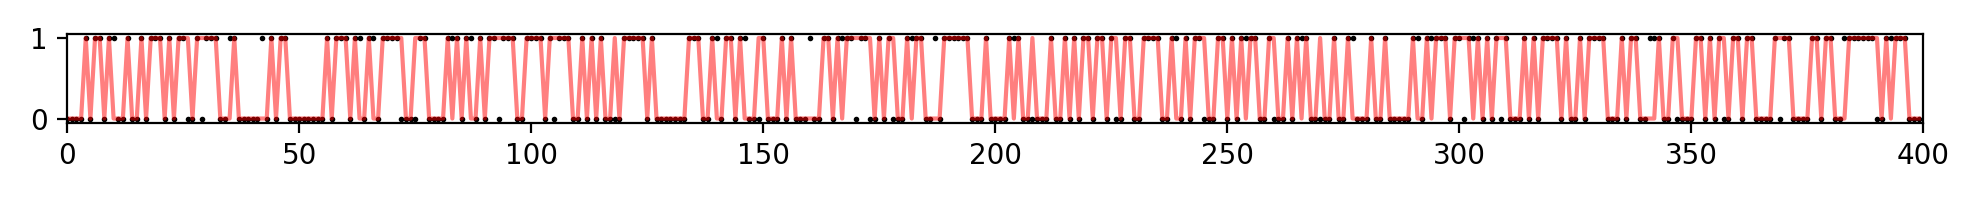

In [21]:
plt.figure(figsize=(9.9,1))
plt.plot(Y[0:400],'.',c='k',markersize=2)
plt.plot((model.predict(X.astype('float64'))>=0.5)[0:400],c='r',alpha=0.5)
plt.xlim([0,400])
plt.tight_layout()

In [22]:
###############################################################################
#  Map numeric neural network weights to normalized colormap values in [0,1]  #
###############################################################################

def num2cmap(x, max_magnitude, cmap, epsilon=1e-9):
    """
    DESCRIPTION:
    This function accepts a float value x and remaps it to a colorscale speci-
    fied via colormap parameter cmap. This function also accepts a limit on
    the expected value |x|--max_magnitude--which aids in normalization of the
    value x to the valid matplotlib colorscale specified by cmap (in string ID
    format). A stability/damping paramter epsilon is also provided to prevent
    against division by zero during the normalization of scalar/vector x which
    is required for cmap(), which itself outputs a 4D color vector per element.
    Thus, an array which has 1 color vector per element of x is output.

    INPUTS & OUTPUTS:
    :param x: input value to be remapped to some colormap defined by cmap
    :type x: float
    :param max_magnitude: max. |x| which could be expected by this function
    :type max_magnitude: float
    :param cmap: some valid matplotlib colormap string ID
    :type cmap: str
    :param epsilon: let epsilon > 0 be small (prevents division by zero)
    :type epsilon: float
    :returns: color vector on the color scale specified, proportional to input
    :rtype: numpy.ndarray
    """
    return cmap(0.5 + x / (epsilon + 2 * max_magnitude))

###############################################################################
#  Diagram an XOR connection between nodes [n, n + 1] in a Galois-style LFSR  #
###############################################################################

def lfsr_xor_connection(n, y_register=0, y_feedback=-0.1, lw=1, xor_size=8):
    """
    DESCRIPTION:
    This function draws the wiring between nodes / bits [n, n + 1] of a Galois
    style LFSR for the specific case where there is an XOR gate receiving 
    feedback tapped from the output of the register. The XOR gate is impro-
    vised from matplotlib markers. The wiring of the register is rerouted from
    its baseline value to form symmetric XOR gate inputs--1 from the n'th bit,
    1 from the feedback from the register output. The output of the register
    is then routed (to the right) to where the (n + 1)'st bit is positioned.
    This function is defined not only with respect to the y-coordinate of the
    LFSR state vector, but also that of the feedback loop (below it). The 
    register size and wiring width are also custom input parameters.

    INPUTS & OUTPUTS:
    :param n: XOR gate is at interval of register bits indexed [n, n + 1]
    :type n: int
    :param y_register: y-coordinate of the register along plot vertical axis
    :type y_register: float
    :param y_feedback: y-coordinate of the feedback loop along vertical axis
    :type y_feedback: float
    :param lw: line width of XOR wiring in plot/diagram (FWDed to matplotlib)
    :type lw: int
    :param xor_size: size of the XOR gate icon improvised from plot markers
    :type xor_size: int
    :returns: nothing (this function only plots things)
    :rtype: None
    """
    #############
    # XOR input #
    #############

    # Wire y-offset into XOR gate
    dy = 0.005

    # Verticle register wiring offset into XOR gate
    plt.plot([n + 0.2, n + 0.2], [-0.1, y_register - dy], lw=1, c='k')

    # Vertically displaced [horiz.] wire feeding XOR gate via tap
    plt.plot([n + 0.2, n + 0.55], [y_register - dy,
        y_register - dy], lw=lw, c='k')

    # Vertically displaced [horiz.] wire feeding XOR gate via register
    plt.plot([n, n + 0.55], [y_register + dy, y_register + dy], lw=1, c='k')

    ############
    # XOR gate #
    ############
    
    # XOR gate contribution from '|' marker
    plt.plot([n + 0.55], [y_register],
        '|', c='k', lw=lw, markersize=xor_size)
    
    # XOR gate contribution from '>' marker
    plt.plot([n + 0.67], [y_register], 
        '>', c='k', lw=lw, markersize=(xor_size - 1))

    ##############
    # XOR output #
    ##############

    # Output wire from XOR gate (level w/ register bits)
    plt.plot([n + 0.6, n + 1], [y_register, y_register], c='k', lw=lw)

###############################################################################
#  Diagram a shift (>>) connection between bits [n, n + 1] in a Galois LFSR   #
###############################################################################

def lfsr_shift_connection(n, y_register=0, lw=1, arrow_size=8):
    """
    """
    # Actual wiring between bits [n, n + 1]
    plt.plot([n, n + 1], [y_register, y_register], c='k', lw=lw)

    # Shift operator on wire b/w bits [n, n + 1]
    plt.plot([n + 0.5], [y_register], '4', c='k',
        lw=lw, markersize=arrow_size)

###############################################################################
#  Initialize the input nodes (aka. the LFSR state vector) of the neural net  #
###############################################################################

def init_input_nodes(deg, seed_bits, markersize=8):
    """
    """
    # For each n'th bit...
    for n in range(deg):

        # Assign black node for bit=1, white for bit=0
        nth_node_color = 'k' if seed_bits[n] else 'w'

        ########################################
        # Plot LFSR n'th input node of network #
        ########################################

        # Plot the n'th node in the register seed state
        plt.plot([n],[0],'o', markersize=markersize, 
            markeredgecolor='k', 
            markerfacecolor=nth_node_color);

###############################################################################
#  Initialize the hidden nodes (2nd layer) of the feedforward neural network  #
###############################################################################

def init_hidden_nodes(deg, y_layer=0.5, markersize=8):
    """
    """
    # For each n'th node...
    for n in range(deg):

        # Plot hidden node @ coordinate (n,y_layer)
        plt.plot([n], [y_layer], 'o', markersize=markersize,
            markeredgecolor='k', markerfacecolor='w');

###############################################################################
#  Initialize the network output/activation node & decision/prediction node   #
###############################################################################

def init_decision_nodes(x_node, y_lower=0.8, y_upper=1, markersize=8):
    """
    """
    # Sigmoidal class prediction node
    plt.plot([x_node],[y_lower],'o',
        markersize=markersize,
        markeredgecolor='k',
        markerfacecolor='w');

    # Thresholded bit prediction node
    plt.plot([x_node],[y_upper],'o',
        markersize=markersize,
        markeredgecolor='k',
        markerfacecolor='w');

###############################################################################
# Given a colormap & set of model weights, map model weights to color values  #
###############################################################################
 
def network_weight_coloration(model, colormap='twilight_shifted'):
    """
    """
    # Max. weight modulus across network
    max_weight = max([
        max(model.weights[0].numpy()), # Layer 0 (input)
        max(model.weights[1].numpy()) # Layer 1 (hidden)
    ])

    # Define colormap via matplotlib
    cmap = plt.get_cmap(colormap)

    # Color values for weights of Layer 0
    layer0_colors = num2cmap(
        model.weights[0].numpy(),
        max_magnitude=max_weight,
        cmap=cmap)

    # Color values for weights of Layer 1
    layer1_colors = num2cmap(
        model.weights[1].numpy(),
        max_magnitude=max_weight,
        cmap=cmap)
    
    # Return color arrays (w/ depth = 4)
    return layer0_colors, layer1_colors

###############################################################################
#  Draw register tap wiring/gates in the LFSR diagram beneath the neural net  #
###############################################################################

def lfsr_polynomial_wiring(deg, taps, y_register=0,
    y_feedback=-0.1, lw=1, arrow_size=8, xor_size=8):
    """
    """
    # For each n'th polynomial coeff...
    for n in range(deg - 1):
        
        #######################################
        # Decorate wiring b/w bits [n, n + 1] #
        #######################################

        # If nonzero n'th coefficient...
        if n > 0 and taps[n]:

            # Place X0R gate w/ feedback taps
            lfsr_xor_connection(n, y_register=y_register, 
                y_feedback=y_feedback, lw=lw, xor_size=xor_size)

        # n'th coefficient is 0...
        else:

            # Place ordinary shift operator
            lfsr_shift_connection(n, y_register=y_register, 
                lw=lw, arrow_size=arrow_size)

###############################################################################
#  Draw the feedback loop wiring in the LFSR diagram beneath the neural net   #
###############################################################################

def lfsr_feedback_loop_wiring(x_midpt, deg,
    y_register=0, y_feedback=-0.1, lw=1, arrow_size=8):
    """
    """
    ##############################################
    # Register I/O wiring (level with LFSR bits) #
    ##############################################

    # Input wire (level with register)
    plt.plot([0, -0.5], [y_register, y_register], c='k', lw=lw)

    # Shift operator decorating input wire
    plt.plot([-0.25], [y_register], '4', c='k',
        markersize=arrow_size)

    # Output wire (level with register)
    plt.plot([deg - 1, deg - 0.5], 
        [y_register, y_register],
        c='k', lw=lw)

    ###################################
    # Descending feedback loop wiring #
    ###################################

    # LFSR output wire, descending into feedback loop
    plt.plot([deg - 0.5, deg - 0.5], [y_register, y_feedback],
        c='k', lw=lw)

    # Shift operator decorating feedback loop wire
    plt.plot([deg - 0.5], [(y_register + y_feedback) / 2],
        '1', c='k', markersize=arrow_size)

    ##################################
    # Ascending feedback loop wiring #
    ##################################

    # LFSR input wire, ascending out of feedback loop
    plt.plot([-0.5, -0.5], [y_register, y_feedback], c='k', lw=lw)

    # Shift operator decorating feedback loop wire
    plt.plot([-0.5],[(y_register + y_feedback) / 2],
        '2',c='k', markersize=arrow_size)

    ##############################
    # Lower feedback loop wiring #
    ##############################

    # Lower LFSR feedback loop wire (spans register length)
    plt.plot([-0.5, deg - 0.5], [y_feedback, y_feedback], c='k', lw=lw)

    # Shift operator decorating feedback loop wire
    plt.plot([x_midpt], [y_feedback], '3', c='k', markersize=arrow_size)

###############################################################################
#  Diagram a Galois-style linear feedback shift register (LFSR), given taps   #
###############################################################################

def draw_lfsr(taps, deg, x_midpt, y_register=0, 
    y_feedback=-0.1, arrow_size=8, lw=1):
    """
    """
    # Within-register wiring
    lfsr_polynomial_wiring(deg,
        taps, y_register=y_register, 
        lw=lw, arrow_size=arrow_size)

    # Feedback loop wiring
    lfsr_feedback_loop_wiring(
        x_midpt, deg=deg,
        y_register=y_register,
        y_feedback=y_feedback,
        lw=lw, arrow_size=arrow_size)

###############################################################################
# Draw the linkage between the network output node & predicted bit (decision) #
###############################################################################

def draw_prediction_link(x_midpt, y_lower=0.8, y_upper=1, lw=1):
    """
    """
    # Edge connecting sigmoid node to thresholded bit prediction
    plt.plot([x_midpt, x_midpt], [y_lower, y_upper], c='k', lw=lw)

###############################################################################
#    Draw weighted network edges of layer 0 of the feedforward neural net     #
###############################################################################

def draw_layer0_linkages(colors, num_input, num_hidden,
    y_hidden=0.5, alpha=0.75, lw=1):
    """
    """
    # For each n'th node in input layer...
    for n in range(num_input):

        # For each m'th node in hidden layer...
        for m in range(num_hidden):

            # Draw link between n'th input & m'th hidden nodes
            plt.plot([n, m], [0, y_hidden], c=colors[n, m, :], 
                alpha=alpha, lw=lw)

###############################################################################
#    Draw weighted network edges of layer 1 of the feedforward neural net     #
###############################################################################

def draw_layer1_linkages(colors, num_hidden, x_midpt, 
    y_hidden=0.5, y_output=0.8, alpha=0.75, lw=1):
    """
    """
    # For each n'th hidden layer node...
    for n in range(num_hidden):
        
        # Output layer's link from n'th hidden neuron
        plt.plot([n, x_midpt], [y_hidden, y_output], 
            c=colors[n, 0, :], alpha=alpha, lw=lw)

###############################################################################
# Draw an imagined feedback connection from the network output to LFSR input  #
###############################################################################

def imagine_feedback_from_network(x_midpt,y_upper=1, y_lower=0,
    y_midpt=-0.5, arrow_size=8, lw=1, linestyle='--'):
    """
    """
    #################################
    # Horizontal feedback loop wire #
    #################################
    
    # Horizontal wire at top of feedback loop
    plt.plot([y_midpt, x_midpt], 
             [y_upper, y_upper], 
             linestyle, c='k', lw=lw)
    
    # Place feedback arrow in center of wire
    plt.plot([x_midpt / 2 - 0.25], [y_upper],
        '3', c='k', markersize=arrow_size)
    
    ###############################
    # Vertical feedback loop wire #
    ###############################
    
    # Descending wire at lefthand side of feedback loop
    plt.plot([-0.5, -0.5], [y_upper, y_lower],
        linestyle, c='k', lw=lw)

    plt.plot([-0.5], [(y_upper + y_lower) / 2],
        '1', c='k', markersize=arrow_size)

###############################################################################
# Draw the wiring of the 2-layer feedforward neural network learning the LFSR #
###############################################################################

def draw_network_wiring(model, config):
    """
    """
    # Map neural network weights to color scale
    c_w0, c_w1 = network_weight_coloration(
        model, colormap=config['cmap'])

    # Plot network weighted edges from input layer to
    # hidden layer, mapping weight values to colors
    draw_layer0_linkages(c_w0, 
        num_input=config['deg'],
        num_hidden=config['deg'], 
        y_hidden=config['y_hidden'], 
        alpha=config['net_link_alpha'],
        lw=config['link_width'])

    # Plot network weighted edges from hidden layer to
    # output layer, mapping weight values to colors
    draw_layer1_linkages(c_w1,
        num_hidden=config['deg'], 
        x_midpt=config['x_mid'],
        y_hidden=config['y_hidden'], 
        y_output=config['y_output'], 
        alpha=config['net_link_alpha'], 
        lw=config['link_width'])

    # Edge connecting sigmoid node to thresholded bit prediction
    draw_prediction_link(x_midpt=config['x_mid'], 
        y_lower=config['y_output'],
        y_upper=config['y_decision'],
        lw=config['link_width'])

###############################################################################
#  Initialize feedforward neural network diagram, populating nodes and edges  #
###############################################################################

def init_network_diagram(model, config, seed_bits):
    """
    """
    #########
    # Edges #
    #########

    # Draw the network connections/edges
    draw_network_wiring(model, config)

    # Draw imagined/pretend feedback from network output to LFSR
    imagine_feedback_from_network(
        x_midpt=config['x_mid'],
        y_upper=config['y_decision'],
        y_lower=config['y_input'],
        arrow_size=config['arrow_size'],
        lw=config['link_width'],
        linestyle=config['net_feedback_linestyle'])

    #########
    # Nodes #
    #########

    # Input LFSR nodes / bits (deg total)
    init_input_nodes(
        deg=config['deg'], 
        seed_bits=seed_bits,
        markersize=config['node_size'])

    # Hidden layer nodes (deg total)
    init_hidden_nodes(
        deg=config['deg'],
        y_layer=config['y_hidden'],
        markersize=config['node_size'])

    # Output probability + decision nodes
    init_decision_nodes(
        x_node=config['x_mid'],
        y_lower=config['y_output'],
        y_upper=config['y_decision'],
        markersize=config['node_size'])

In [2]:
from numpy import max

config = {
    'figsize': (9.9, 6),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'plasma',#'twilight_shifted',
    'y_input': 0,
    'y_hidden': 0.5,
    'y_output': 0.8,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'y_lim': [-0.2, 1.1],
    'num_hidden': deg,
    'num_input': deg,
    'node_size': 8,
    'link_width': 1,
    'net_link_alpha': 0.75,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

#############################
# Set up shop in new figure #
#############################

# New figure
plt.figure(figsize=config['figsize'])

# Draw LFSR corrsponding to tap polynomial
draw_lfsr(taps=str2vec(hex2bin(
    coeff_catalog[p], config['deg'])), 
    deg=config['deg'], 
    x_midpt=config['x_mid'],
    y_register=config['y_input'],
    y_feedback=config['y_LFSR_loop'],
    arrow_size=config['arrow_size'],
    lw=config['link_width'])

# Initialize neural net drawing
init_network_diagram(model=model,
    config=config, seed_bits=X[0,:])

###############
# Format axes #
###############

# Vertical axis span
plt.ylim(config['y_lim']);

# Remove all axis ticks
plt.xticks([]);
plt.yticks([]);

NameError: name 'deg' is not defined